In [1]:
#pip install financepy

## Advanced Derivatives Final Assignment {-}

### Team Members: {-}

#### Marcel Santos de Carvalho, id 79803 {-}
#### Alex Palacios, id 73713 {-}
#### Loris Baudry, id 79794 {-}


In [17]:
import pandas as pd
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import math

from financepy.utils import *
from financepy.products.equity import *

####################################################################
# FINANCEPY BETA Version 0.204 - This build:  02 Nov 2021 at 10:17 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# Question 1 - Black-Scholes-Merton Hedging {-}

### 1a. {-}


We can determine the value of an option by applying the Black Scholes Option Formula:

$$ C(S_t,t) = N(d_1)S_t-N(d_2)Ke^{-rt}$$

Where:

$$  d_1=\frac{ln\frac{S_t}{K}+(r+\frac{\sigma^2}{2})t}{\sigma\sqrt{t}}$$

$$ d_2=d_1-\sigma\sqrt{t}$$


Using financepy's function 'EquityVanillaOption_' we can estimate a plain vanilla Option's price and risk measures. Considering that we are pricing a call, we can assume the following inputs for our computation based on a Call option on the VIXY with a strike option of $22.00.

#### Inputs for Call Price: {-} 

1. The current value of the asset is $$S_0 = \$19.15$$
2. The option tenor is $$T = 2 year$$
3. The risk free rate is $$r_f = 0.828\%$$
4. The strike price is $$K = \$22.00$$
5. The stock's volatility is $$sigma = 132.609\%$$
6. The expected future dividend yield is $$d = 0.85\%$$


In [3]:
# We will first establish the expire date as a function of T, which is the time to expiry

valuation_date = Date(30, 11, 2021)

expiry_date = valuation_date.add_years(2)

expiry_date

30-NOV-2023

In [4]:
# Then, we will assign the value to our inputs required to create our Call option.
# The inputs we will be using are the ones corresponding to a Call on the VIXY ETF. 

stock_price = 19.15
strike_price = 22
volatility = 1.32609
interest_rate = 0.00828
dividend_yield = 0.00850

In [5]:
# Now, we can creat a Call option object by using EquityVanillaOption function

call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)

In [6]:
# We need to define the discount curve and the Dividends curve as well

discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

In [7]:
# We will use the Black Scholes model as our standard model

model = BlackScholes(volatility)

In [8]:
# Now, we can compute the call value at any chosen date before the time to expiry

call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
print(call_value)

11.80473279145044


### 1b. {-}

In [9]:
# At the same time, we can compute the corresponding call delta for the created option

call_delta = call_option.delta(valuation_date, stock_price, discount_curve, dividend_curve, model)
print(call_delta)

0.79247405614197


### 1c. {-}

Now, we will test the so called "Delta Dynamic Hedging" strategy. To do so, we will create a hedged position by constructing the following portfolio:
    
$$\pi = \Delta_t S_t - C(S_t,t) + Cash$$

To test the efficiency of this hedge, we will create a function that simulates the path of a stock and that replicates a dynamic hedge strategy. At the end of the strategy, the value of the hedged portfolio should be close to zero. This means that the sum of the cash and the stock position should offset as closely as possible the payoff at expiration. Given that we will be writting the call, the delta of the option will be negative. To offset it we will need to go long the stock, which we will finance by borrowing money at the risk free rate. This can be seen as follow:

$$HedgePosition= \Delta S-Borrowing=CallValue$$

At expiration, the Call Value should be equal to the option Payoff.

In [10]:
def OptionSim(n_years_, steps_per_year_, stock_price_, strike_price_, mu_, volatility_, interest_rate_, dividend_yield_):
    """
    
    """
    # We wlll define a new dataFrame to store the important features of the strategy implementation
    
    columns=('Period','Spot','CallValue','Delta','Shares_bought','Cost',
             'Interest','Cash','Shares','Shares_$','TotalValue','Error')
    df = pd.DataFrame(columns=columns)
    
    # Here we define the initial inputs for loop
    
    periods = n_years_ * steps_per_year_ # Computing total number of porfolio rebalances
    valuation_date_f = Date(30, 11, 2021)
    expiry_date_f = valuation_date_f.add_years(n_years_) 
    results=[]
    cash = 0
    shares = 0
    stocks_b=0
    stock_pos_m=0
    cost=0
    roll=0
    spot=0
    dt = 1/steps_per_year_

    # Calling on financepy, we create an Call object
    
    call_option_i = EquityVanillaOption(expiry_date_f, strike_price_, OptionTypes.EUROPEAN_CALL)
    
    # With a Loop we will simulate the evolution of the Stock price and the heddging rebalance of the Hedged Portfolio
    for rebal in range(0,periods+1):
        
        # We modify the valuation date one jump ahead at a time.
        # The number of periods is equal to the number of years times the number of rebalances per year
        
        new_val_date_f = valuation_date_f.add_years(rebal*dt)
        p = rebal*dt
        
        # We simulate the evolution of the stock price at each jump
        
        if p>0:
            spot=spot*exp((mu_ - 0.5*(volatility_**2))*dt + volatility_*sqrt(dt)*np.random.randn())
        else:
            spot=stock_price_ # We set the spot equal to S_0 at initiation of the count
        
        # We compute the option value and the option delta at each point in time
        
        discount_curve_ = DiscountCurveFlat(new_val_date_f, interest_rate_)
        dividend_curve_ = DiscountCurveFlat(new_val_date_f, dividend_yield_)
        model_ = BlackScholes(volatility_)
        
        call_value_=call_option_i.value(new_val_date_f, spot, discount_curve_, dividend_curve_, model_)
        call_delta_=-call_option_i.delta(new_val_date_f, spot, discount_curve_, dividend_curve_, model_) # Delta is negative as we are short the call
        
        # We perform the delta hedge by buying or selling the required number of shares to have a  
        # position equal to delta*shares
        
        roll=cash*((exp(interest_rate_*dt))-1) # This is the amount of interest generated in per period
        cash=cash*exp(interest_rate_*dt) # Cash is rolled over one period 
        if new_val_date_f==valuation_date_f: 
            cash=call_value_ # Sell the call at t=0
        shares_b = -(call_delta_ + shares) # Computes number of shares bought, positive number means negative cash
        
        # Updating the variables
        
        shares= -call_delta_
        cost= -shares_b*spot
        cash-= shares_b*spot
        stock_pos_m=shares*spot
        HedgeValue = cash + shares*spot
        error = HedgeValue - call_value_
       
    
        # Feeding dataFrame
        L = [p,spot, call_value_, call_delta_, shares_b, cost, roll, cash, shares,stock_pos_m, HedgeValue, error]
        
        df.loc[len(df)] = L
    
    # Preparing tuple with final results
    records = df[['Spot', 'CallValue', 'Shares', 'Cash', 'TotalValue', 'Error']].to_records(index=False)
    results = records[len(records)-1]
    
    return results

These are the results of our function in which the results of the tuple are:
1. Spot
2. Call Value
3. Shares held in the hedging portfolio
4. Cash held in the hedging portfolio
5. Total value of Cash and Shares held in the portfolio
6. Total value against option payoff

In [11]:
results = OptionSim(1, 52, 19.15, 22, 0.10, 1.32609, 0.00828, 0.00850)
results

(3.67677014, 0., 0., 0.34623453, 0.34623453, 0.34623453)

### 1d. {-}

Now, we will create a function to simulate 1,000 different paths for a stock with the following characteristics:

1. The current value of the asset is $$S_0 = \$100.00=Strike$$
2. The option tenor is $$T = 1 year$$
3. The risk free rate and stock's expected return are $$r_f = \mu = 5.00\%$$
4. The strike price is $$K = \$100.00$$
5. The stock's volatility is $$sigma = 20.00\%$$
6. The expected future dividend yield is $$d = 0.00\%$$


In [12]:
def IterateSim(n_scenarios, n_years, steps_per_year, stock_price, strike_price, mu, volatility, interest_rate, dividend_yield):
    """

    """
    errors = []
    for x in range (0, n_scenarios):
        results = OptionSim(n_years_=n_years, steps_per_year_=steps_per_year, stock_price_=stock_price, strike_price_=strike_price, mu_=mu, volatility_=volatility, interest_rate_=interest_rate, dividend_yield_=dividend_yield)
        errors.append(results[-1]) # Here we create a vector with the error at the final date of each path
    mean_error = np.average(errors)
    print ("N Scenarios: ", n_scenarios)
    print ("Mean Error", mean_error)

After creating the function, we will look for the mean error of the dynamic hedging strategy

In [13]:
IterateSim(1000, 1, 12, 100, 100, 0.05, 0.20, 0.05, 0)

N Scenarios:  1000
Mean Error 0.08357313603422138


As we can see, on average the error is fairly close to zero, which means that the hedging strategy does pretty well on average. Next we will review the impact of doing rebalances more often during the same time frame.

### 1e. {-}

We will modify slightly the previous fucntion in order to get as an output a dataframe containing the final prices, the corresponding error, the total value of the hedging portfolio and the option payoff for simulations in which the rebalacing occurs 12, 52 and 252 times per year.

In [14]:
# Creating a new function that outputs prices and errors as a dataFrame

def IterateSim_2(n_scenarios_i, n_years_i, steps_per_year_i, stock_price_i, strike_price_i, mu_i, volatility_i, interest_rate_i, dividend_yield_i):
    """

    """
    prices = [] # We create an empty vector to store the final price of the stock
    errors = [] # We create an empty vector to store the error at the final stage of each path
    payoff = [] # We create an empty vector to store the final payoff of the option
    TotalV = [] # We create an empty vector to store the final total value of the cash held and the stock position
    for x in range (0, n_scenarios_i):
        results = OptionSim(n_years_=n_years_i, steps_per_year_=steps_per_year_i, stock_price_=stock_price_i, strike_price_=strike_price_i, mu_=mu_i, volatility_=volatility_i, interest_rate_=interest_rate_i, dividend_yield_=dividend_yield_i)
        prices.append(results[0])
        errors.append(results[-1])
        payoff.append(results[1])
        TotalV.append(results[-2])
    df = pd.DataFrame(
    {'Prices': prices,
     'Errors': errors,
     'Payoff': payoff,
     'TotalV': TotalV
    })
    return df

We will now perform the corresponding simulations

In [15]:
# 1000 simulations for monthly rebalances

df_12 = IterateSim_2(1000, 1, 12, 100, 100, 0.05, 0.20, 0.05, 0)

In [16]:
# Mean error for the hedging stragey with monthly rebalances

np.average(df_12['Errors'])

-0.001347441443013409

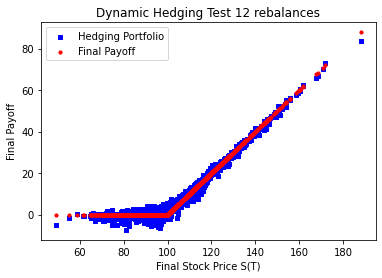

In [17]:
import matplotlib.pyplot as plt

df_12['Payoffs_e_12']=df_12['Errors']+df_12['Payoff']
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_12['Prices'], df_12['Payoffs_e_12'], s=10, c='b', marker="s", label='Hedging Portfolio')
ax1.scatter(df_12['Prices'],df_12['Payoff'], s=10, c='r', marker="o", label='Final Payoff')
plt.legend(loc='upper left');
plt.title('Dynamic Hedging Test 12 rebalances')
plt.xlabel('Final Stock Price S(T)')
plt.ylabel('Final Payoff')
plt.show()

In [18]:
# 1000 simulations for weekly realances

df_52 = IterateSim_2(1000, 1, 52, 100, 100, 0.05, 0.2, 0.05, 0)

In [19]:
# Mean error for the hedging stragey with weekly rebalances

np.average(df_52['Errors'])

0.002005111562484025

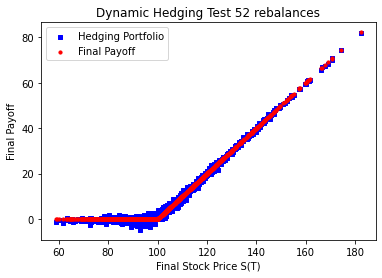

In [20]:
df_52['Payoffs_e_52']=df_52['Errors']+df_52['Payoff']
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_52['Prices'], df_52['Payoffs_e_52'], s=10, c='b', marker="s", label='Hedging Portfolio')
ax1.scatter(df_52['Prices'],df_52['Payoff'], s=10, c='r', marker="o", label='Final Payoff')
plt.legend(loc='upper left');
plt.title('Dynamic Hedging Test 52 rebalances')
plt.xlabel('Final Stock Price S(T)')
plt.ylabel('Final Payoff')
plt.show()

In [21]:
# 1000 simulations for daily rebalances

df_252 = IterateSim_2(1000, 1, 252, 100, 100, 0.05, 0.2, 0.05, 0)

In [22]:
# Mean error for the hedging stragey with daily rebalances

np.average(df_252['Errors'])

0.0004178050380292961

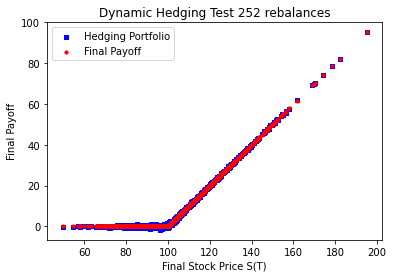

In [23]:
df_252['Payoffs_e_252']=df_252['Errors']+df_252['Payoff']
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_252['Prices'], df_252['Payoffs_e_252'], s=10, c='b', marker="s", label='Hedging Portfolio')
ax1.scatter(df_252['Prices'],df_252['Payoff'], s=10, c='r', marker="o", label='Final Payoff')
plt.legend(loc='upper left');
plt.title('Dynamic Hedging Test 252 rebalances')
plt.xlabel('Final Stock Price S(T)')
plt.ylabel('Final Payoff')
plt.show()

As we can see in the graphs above, the Dynamic Hedging strategy works pretty well and its' accuracy increases as the number of rebalances goes up. This makes sense as the delta measure reflects the change in value of the option when the stock changes by small amounts. If the rebalances take long, the changes in the stock prices can be large enough to impact negatively in the hedging strategy perfrormance.

### 1f. {-}

To take the analysis one step further, we will compare the variance of the error in addition to the mean error as the number of rebalances increase. We can already expect the variance to diminish given the graph observed above. 

In [24]:
results_df = pd.DataFrame(columns = ['Number of rebalances', 'Mean Error', 'Error Variance'])

L12 = [12, np.average(df_12['Errors']), np.var(df_12['Errors'])]
L52 = [52, np.average(df_52['Errors']), np.var(df_52['Errors'])]
L252 = [252, np.average(df_252['Errors']), np.var(df_252['Errors'])]

results_df.loc[len(results_df)] = L12
results_df.loc[len(results_df)] = L52
results_df.loc[len(results_df)] = L252

results_df

Number of rebalances  Mean Error  Error Variance
0                  12.0   -0.001347        3.475879
1                  52.0    0.002005        1.004891
2                 252.0    0.000418        0.176771

As we expected, the variance of the errors decreases, similar to the mean error, when the number of rebalances goes up.

### 1g. {-}

Finally, we will see what happens to the error and the variance of the error when we fix the number of rebalances per year and change the drift of the stock. Let us remember that when we started the simulations we assumed that the risk free rate was equal to the drift of the option, which is not usually the case in practice. 

In [25]:
mu_25 = IterateSim_2(1000, 1, 52, 100, 100, 0.025, 0.2, 0.05, 0)

In [26]:
mu_50 = IterateSim_2(1000, 1, 52, 100, 100, 0.05, 0.2, 0.05, 0)

In [27]:
mu_75 = IterateSim_2(1000, 1, 52, 100, 100, 0.075, 0.2, 0.05, 0)

In [28]:
mu_100 = IterateSim_2(1000, 1, 52, 100, 100, 0.10, 0.2, 0.05, 0)

In [29]:
results_df = pd.DataFrame(columns = ['Mu', 'Mean Error', 'Error Variance'])

L25 = [2.5, np.average(mu_25['Errors']), np.var(mu_25['Errors'])]
L50 = [5.0, np.average(mu_50['Errors']), np.var(mu_50['Errors'])]
L75 = [7.5, np.average(mu_75['Errors']), np.var(mu_75['Errors'])]
L100 = [10, np.average(mu_100['Errors']), np.var(mu_100['Errors'])]


results_df.loc[len(results_df)] = L25
results_df.loc[len(results_df)] = L50
results_df.loc[len(results_df)] = L75
results_df.loc[len(results_df)] = L100

results_df

Mu  Mean Error  Error Variance
0   2.5    0.016494        0.911191
1   5.0    0.045134        0.838204
2   7.5    0.029610        0.852560
3  10.0    0.006429        0.856287

It is interesting to see how the change in the value of mu doesn't seem to impact much on the absolute value of the mean error nor of the the error variance. This is somehow expected given that the Black and Scholes model doesn't depend on the real drift of the stock but allow us to price the option based on a risk-neutral model. This result shows that this characteristic of the model actually holds and, therefore, the price of our option will not depend upon the stock's drift or the real probabilites embedded in the evolution of the stock price

# Question 2 - Transaction Costs {-}

### 2a. {-}  

We will now consider the impact of transaction cost in our dynamic hedging strategy. We will set a bid and ask price based on the observed spot price as follows:

$$Ask=Spot*(1+\frac{t}{2})$$

And

$$Bid=Spot*(1-\frac{t}{2})$$

Where t% represents our transaction cost for doing a round trip. This means that you pay t/2 when you buy and you pay t/2 when you sell.

In [30]:
def OptionSim_transactioncost(n_years_, steps_per_year_, stock_price_, strike_price_, mu_, volatility_, interest_rate_, dividend_yield_, t):
    """
    
    """
    # We wlll define a new dataFrame to store the important features of the strategy implementation
    
    columns=('Period','Spot','Bid','Ask','CallValue','Delta','Shares_bought',
             'Transac_Cost','Cost','Interest','Cash','Shares','Shares_$',
             'TotalValue','Error')
    df = pd.DataFrame(columns=columns)
    
    # Here we define the initial inputs for loop
    
    periods = n_years_ * steps_per_year_ # Computing total number of porfolio rebalances
    valuation_date_f = Date(30, 11, 2021)
    expiry_date_f = valuation_date_f.add_years(n_years_)
    results=[]
    cash = 0
    shares = 0
    stocks_b=0
    stock_pos_m=0
    cost=0
    roll=0
    spot=0
    ask=0
    bid=0
    transaction_cost=0
    dt = 1/steps_per_year_

    # Calling on financepy, we create a Call object
    
    call_option_i = EquityVanillaOption(expiry_date_f, strike_price_, OptionTypes.EUROPEAN_CALL)
    
    # With a Loop we will simulate the evolution of the Stock price and the heddging rebalance of the Hedged Portfolio
    for rebal in range(0,periods+1):
        
        # We modify the valuation date one jump ahead at a time.
        # The number of periods is equal to the number of years times the number of rebalances per year
        
        new_val_date_f = valuation_date_f.add_years(rebal*dt)
        p = rebal*dt
        
        # We simulate the evolution of the stock price at each jump     
             
        if p>0:
            spot=spot*exp((mu_ - 0.5*(volatility_**2))*dt + volatility_*sqrt(dt)*np.random.randn())
        else:
            spot=stock_price_ # We set the spot equal to S_0 at initiation of the country
        
        # Based on the observed spot price we establish a bid and ask price
             
        bid=spot*(1-0.5*t)
        ask=spot*(1+0.5*t)
             
        # We compute the option value and the option delta at each point in time
             
        discount_curve_ = DiscountCurveFlat(new_val_date_f, interest_rate_)
        dividend_curve_ = DiscountCurveFlat(new_val_date_f, dividend_yield_)
        model_ = BlackScholes(volatility_)
        
        call_value_=call_option_i.value(new_val_date_f, spot, discount_curve_, dividend_curve_, model_)
        call_delta_=-call_option_i.delta(new_val_date_f, spot, discount_curve_, dividend_curve_, model_) # Delta is negative as we are short the call
        
        # We perform the delta hedge by buying or selling the required number of shares to have a  
        # position equal to delta*shares
        
        roll=cash*((exp(interest_rate_*dt))-1) # This is the amount of interest generated per period
        cash=cash*exp(interest_rate_*dt) # Cash is rolled over one period 
        if new_val_date_f==valuation_date_f: 
            cash=call_value_ # Sell the call at t=0
        shares_b = -(call_delta_ + shares) # Computes number of shares bought, positive number means negative cash
        
        # We will store the cummulative transaction costs
             
        transaction_cost = transaction_cost +  abs(shares_b*t/2) 
         
        # Updating the variables
        
        shares= -call_delta_
        
        # If we buy shares we pay the ask, if we sell we receive the bid
             
        if shares_b > 0:
            cost= -shares_b*ask
            cash-= shares_b*ask
        else:
            cost= -shares_b*bid
            cash-= shares_b*bid
        
        # Regardless of the price paid or received, the stock position is valued at spot
             
        stock_pos_m=shares*spot
        HedgeValue = cash + shares*spot
        error = HedgeValue - call_value_
       
    
        # Feeding dataFrame
        L = [p,spot, bid, ask, call_value_, call_delta_, shares_b, transaction_cost, cost, roll, cash, shares,stock_pos_m, HedgeValue, error]
        
        df.loc[len(df)] = L
    
    # Preparing tuple with final results
    records = df[['Spot', 'CallValue', 'Shares', 'Cash', 'TotalValue', 'Error']].to_records(index=False)
    results = records[len(records)-1]
    
    return results                             

In [31]:
results = OptionSim_transactioncost(1, 52, 19.15, 22, 0.10, 1.32609, 0.00828, 0.00850, 0.005)
results

(20.42024365, 0., 0., -2.82300866, -2.82300866, -2.82300866)

In this case, the results of our function are represented as a tuple too containing the following data:
1. Spot
2. Call Value
3. Shares held in the hedging portfolio
4. Cash held in the hedging portfolio
5. Total value of Cash and Shares held in the portfolio
6. Total value against option payoff

Until this point, it would seem that transaction costs don't add much to the amount of the error. To test this idea we will now run different simulations by changing the value of t.

### 2b. {-}

We will now create a similar function to the one created in the previous question that will allow us to run a simulation for 1,000 paths. This time we will change the transaction costs in addition to the number of rebalances per year.

In [32]:
def IterateSim_transactioncost(n_scenarios, n_years, steps_per_year, stock_price, strike_price, mu, volatility, interest_rate, dividend_yield, t):
    """

    """
    prices = [] # We create an empty vector to store the final price of the stock
    errors = [] # We create an empty vector to store the error at the final stage of each path
    payoff = [] # We create an empty vector to store the final payoff of the option
    TotalV = [] # We create an empty vector to store the final total value of the cash held and the stock position
    for x in range (0, n_scenarios):
        results = OptionSim_transactioncost(n_years_=n_years, steps_per_year_=steps_per_year, stock_price_=stock_price, strike_price_=strike_price, mu_=mu, volatility_=volatility, interest_rate_=interest_rate, dividend_yield_=dividend_yield, t=t)
        prices.append(results[0])
        errors.append(results[-1])
        payoff.append(results[1])
        TotalV.append(results[-2])
    df = pd.DataFrame(
    {'Prices': prices,
     'Errors': errors,
     'Payoff': payoff,
     'TotalV': TotalV
    })
    return df

In [33]:
# Here, we will run an exercise of 1000 simulations for 12, 52 and 252 rebalances per year and with t = 0.5%, 1.0% and 2.0%

# Simulations for t=0.5%
df_12_0005 = IterateSim_transactioncost(1000, 1, 12, 100, 100, 0.05, 0.2, 0.05, 0, 0.005)
df_52_0005 = IterateSim_transactioncost(1000, 1, 52, 100, 100, 0.05, 0.2, 0.05, 0, 0.005)
df_252_0005 = IterateSim_transactioncost(1000, 1, 252, 100, 100, 0.05, 0.2, 0.05, 0, 0.005)

# Simulations for t=1.0%
df_12_001 = IterateSim_transactioncost(1000, 1, 12, 100, 100, 0.05, 0.2, 0.05, 0, 0.01)
df_52_001 = IterateSim_transactioncost(1000, 1, 52, 100, 100, 0.05, 0.2, 0.05, 0, 0.01)
df_252_001 = IterateSim_transactioncost(1000, 1, 252, 100, 100, 0.05, 0.2, 0.05, 0, 0.01)

# Simulations for t=2.0%
df_12_002 = IterateSim_transactioncost(1000, 1, 12, 100, 100, 0.05, 0.2, 0.05, 0, 0.02)
df_52_002 = IterateSim_transactioncost(1000, 1, 52, 100, 100, 0.05, 0.2, 0.05, 0, 0.02)
df_252_002 = IterateSim_transactioncost(1000, 1, 252, 100, 100, 0.05, 0.2, 0.05, 0, 0.02)
                                        

In [34]:
results_df = pd.DataFrame(columns = ['N', 'Mean Error - t = 0.5%', 'Mean Error - t = 1%', 'Mean Error - t = 2%'])

L12 = [12, np.average(df_12_0005['Errors']), np.average(df_12_001['Errors']), np.average(df_12_002['Errors'])]
L52 = [52, np.average(df_52_0005['Errors']), np.average(df_52_001['Errors']), np.average(df_52_002['Errors'])]
L252 = [252, np.average(df_252_0005['Errors']), np.average(df_252_001['Errors']), np.average(df_252_002['Errors'])]

results_df.loc[len(results_df)] = L12
results_df.loc[len(results_df)] = L52
results_df.loc[len(results_df)] = L252

results_df

N  Mean Error - t = 0.5%  Mean Error - t = 1%  Mean Error - t = 2%
0   12.0              -0.445641            -0.936813            -1.820501
1   52.0              -0.712696            -1.473253            -3.016700
2  252.0              -1.421441            -2.860512            -5.640406

From the table above, we can see that the mean error values increase when transaction costs increase. It makes sense since the difference of the terminal portfolio value and the payoff will be greater because the cash account is affected by those costs. 

Another important result is that hedging errors now go up as the number of rebalances increase even in the presence of transaction costs. This is also somehow expected as more transaction costs paid given that there are more transactions, which more than offset the benefit shown in the previous question from more frequent rebalncing dates.

Text(0.5, 1.0, 'Transactions cost of 2.0%')

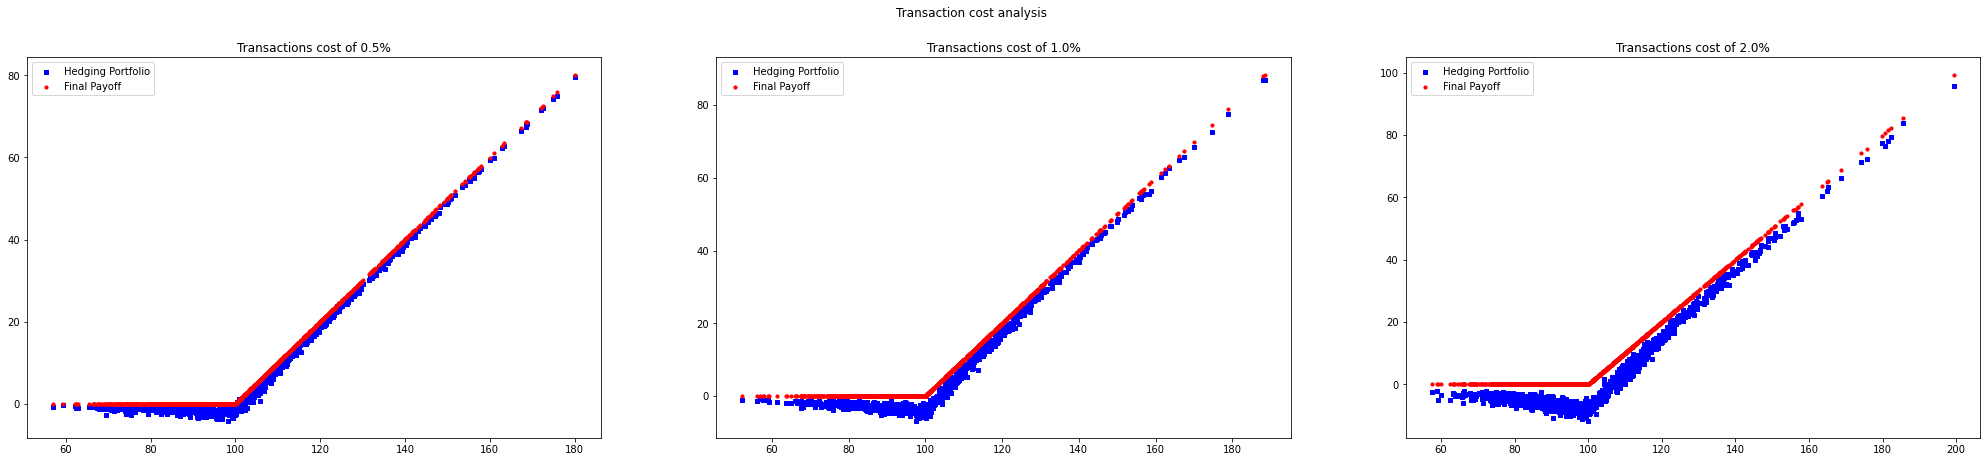

In [35]:
df_252_0005['Payoffs_e_252_0.5']=df_252_0005['Errors']+df_252_0005['Payoff']
df_252_001['Payoffs_e_252_0.1']=df_252_001['Errors']+df_252_001['Payoff']
df_252_002['Payoffs_e_252_0.2']=df_252_002['Errors']+df_252_002['Payoff']


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35,7))
fig.suptitle('Transaction cost analysis')
ax1.scatter(df_252_0005['Prices'], df_252_0005['Payoffs_e_252_0.5'], s=10, c='b', marker="s", label='Hedging Portfolio')
ax1.scatter(df_252_0005['Prices'],df_252_0005['Payoff'], s=10, c='r', marker="o", label='Final Payoff')
ax1.legend(loc='upper left');
ax1.set_title('Transactions cost of 0.5%')
ax2.scatter(df_252_001['Prices'], df_252_001['Payoffs_e_252_0.1'], s=10, c='b', marker="s", label='Hedging Portfolio')
ax2.scatter(df_252_001['Prices'],df_252_001['Payoff'], s=10, c='r', marker="o", label='Final Payoff')
ax2.legend(loc='upper left');
ax2.set_title('Transactions cost of 1.0%')
ax3.scatter(df_252_002['Prices'], df_252_002['Payoffs_e_252_0.2'], s=10, c='b', marker="s", label='Hedging Portfolio')
ax3.scatter(df_252_002['Prices'],df_252_002['Payoff'], s=10, c='r', marker="o", label='Final Payoff')
ax3.legend(loc='upper left');
ax3.set_title('Transactions cost of 2.0%')

 Finally, the transaction cost impact always pushes the error into the negative side of the pay off graph which suggests that the trader will always suffer a negative impact from transaction cost.

### 2c. {-}

Now, there is a model suggested by Leland (1985), which suggest that the impact of transaction costs can be incorporated into the option price by changing the volatility used to compute its price. The suggested change is the following:

$$\sigma^{Adjusted} = \sigma\Bigg(1+\sqrt{\frac{2}{\pi}}\frac{t}{\sigma}\sqrt{N}\Bigg)^{\frac{1}{2}}$$

This augmented volatility should derive into a higher option price. This additional premium should offset the transanction cost impact. In this part, we will compare the call values using both the original and the adjusted volatilities for the call option used above for the simulations with a set of transaction costs of 0.5%, 1% and 2%.

In [36]:
# We define the common variables that we will be using to create the different options

valuation_date = Date(30, 11, 2021)
expiry_date = valuation_date.add_years(1)

stock_price = 100
strike_price = 100
volatility = 0.20
interest_rate = 0.05
dividend_yield = 0.0

steps_per_year = 52
volatility = 0.20

# We create the Call object and the Discount curves to value the Call option

call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

In [37]:
# First, we will compute the adjusted Volatility based on the original 20.0% volatiltiy
# 0.5% of transaction costs and assuming 52 rebalances per year.

t=0.005
adjusted_volatility = volatility*(1+((2/np.pi)**0.5)*(t/volatility)*(steps_per_year**0.5))**0.5
print ("Adjusted Volatility:", adjusted_volatility)

Adjusted Volatility: 0.21390097566806843


In [38]:
# Comparison BS and BS with adjusted volatility for transaction costs equal to 0.5%

# BS model with original volatility
model = BlackScholes(volatility)
call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

# BS model with adjusted volatility
model_adjusted = BlackScholes(adjusted_volatility)
call_value_adjusted = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model_adjusted)   

print ("Call value: ", call_value)
print ("Call value using Adjusted Volatility:", call_value_adjusted)
print ("Price increase:", (call_value_adjusted - call_value))
print ("Price increase as %:", ((call_value_adjusted - call_value) / call_value)*100)

Call value:  10.450575619322274
Call value using Adjusted Volatility: 10.973069085705152
Price increase: 0.522493466382878
Price increase as %: 4.999662080018153


In [39]:
# Now we compute the adjusted Volatility for transaction costs of 1.0%

t=0.01
adjusted_volatility = volatility*(1+((2/np.pi)**0.5)*(t/volatility)*(steps_per_year**0.5))**0.5
print ("Adjusted Volatility:", adjusted_volatility)

Adjusted Volatility: 0.22695209799317384


In [40]:
# Comparison BS and BS with adjusted volatility for transaction costs equal to 1.0%

# BS model with original volatility
model = BlackScholes(volatility)
call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

# BS model with adjusted volatility
model_adjusted = BlackScholes(adjusted_volatility)
call_value_adjusted = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model_adjusted)   

print ("Call value: ", call_value)
print ("Call value using Adjusted Volatility:", call_value_adjusted)
print ("Price increase:", (call_value_adjusted - call_value))
print ("Price increase as %:", ((call_value_adjusted - call_value) / call_value)*100)

Call value:  10.450575619322274
Call value using Adjusted Volatility: 11.464970583491281
Price increase: 1.014394964169007
Price increase as %: 9.706594173563726


In [41]:
# Now we compute the adjusted Volatility for transaction costs of 1.0%

t=0.02
adjusted_volatility = volatility*(1+((2/np.pi)**0.5)*(t/volatility)*(steps_per_year**0.5))**0.5
print ("Adjusted Volatility:", adjusted_volatility)

Adjusted Volatility: 0.2510269100455295


In [42]:
# Comparison BS and BS with adjusted volatility for transaction costs equal to 2.0%

# BS model with original volatility
model = BlackScholes(volatility)
call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

# BS model with adjusted volatility
model_adjusted = BlackScholes(adjusted_volatility)
call_value_adjusted = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model_adjusted)   

print ("Call value: ", call_value)
print ("Call value using Adjusted Volatility:", call_value_adjusted)
print ("Price increase:", (call_value_adjusted - call_value))
print ("Price increase as %:", ((call_value_adjusted - call_value) / call_value)*100)

Call value:  10.450575619322274
Call value using Adjusted Volatility: 12.374848083156243
Price increase: 1.9242724638339688
Price increase as %: 18.413076312046808


Interpretation of results: 

We can see that the adjusted volatility increases when the transaction costs increase. This translates into a higher premium for the call option reflecting the fact that the hedging is now more expensive. Therefore, increasing the volatility with the adjusted volatility permits to incorporate into the call price part of the expected negative impact from transaction costs. 

# Question 3 - Implied density of Terminal Stock Price and Volatility Skew {-}

### 3a. {-}

For this question, we will be trying to derive the implied stock's price distribution at maturity. The idea will be that starting from the implied volatility given market prices we can get the price distribution using the Breedon-Litzenberg forumula. 

The firs step will be to assume that we observed the volatility smile for an equity function, which we managed to fit using the following equation:

$$\sigma(x)=ax^{2}+bx+c$$

Where:

$$a=0.025$$
$$b=-0.225$$
$$c=0.50$$

Now, we will define the "moneyness" of the stock as $x=\frac{K}{S(0)}$. In this case, the stock price at inception is going to be set at $S(0)=100$. Finally, we will get the implied distribution of the stock's price at maturity using the Breedon-Litzenberg forumula. The idea is that the price of a call option can be expressed as:

$$V(t)=Z(t,T)\int_0^\infty g(S)Max(S-K,0)\mathrm{d}S$$

The idea is to approximate the probability function of S(T). $g(S)$, as follows:

$$g(K)\approx \frac{1}{Z(t,T)}\frac{V(K+dK)-2V(K)+V(K-dK)}{dK^2}$$


In [43]:
# We will first define the initial inputs

S = 100
r = 0.05
T = 1
a = 0.025
b = -0.225
c = 0.5
d=0
df = exp(-r*T)

In [44]:
# Now, we will create a list containing different values for the strike which will go from 1 to 401

l = []
for sk in range(1, 401):
    l.append(sk)
    
# Next, we will compute the corresponding moneyness to each of those strikes
    
mn =[]
for k in l:
    mn.append(k / S)
    
# Finally, we will use the equation that fits the volatility smile to recover the implied volatilityes for each strike

vols = []
for vol in mn:
    vols.append(a*vol**2 + b*vol + c)

In [45]:
valuation_date = Date(30, 11, 2021)
expiry_date = valuation_date.add_years(T)

# Now, we will generate the discount curves for our options, which are going to be the same for every option
discount_curve = DiscountCurveFlat(valuation_date, r)
dividend_curve = DiscountCurveFlat(valuation_date, d)

# Now, we will create a new option for each strike we have and compute its price
BS = []
Strike=1
for bs in vols:
    call_option = EquityVanillaOption(expiry_date, Strike, OptionTypes.EUROPEAN_CALL)
    model = BlackScholes(bs)
    BS.append(call_option.value(valuation_date, S, discount_curve, dividend_curve, model))
    Strike = Strike + 1

In [46]:
# Next, we will estimate the probability function with the equation suggested above

g = [0]
for G in range(1, len(l)-1):
    g.append((1/df)*(BS[G + 1] - 2*BS[G] + BS[G - 1])/1)
g.append(0)

In [47]:
# Here, we will present a Dataframe with the results

df_smile = pd.DataFrame(columns=['Option Strike', 'Inverse Moneyness', 'Option Vol', 'Black Scholes', 'Density'])
df_smile['Option Strike'] = l
df_smile['Inverse Moneyness'] = mn
df_smile['Option Vol'] = vols
df_smile['Black Scholes'] = BS
df_smile['Density'] = g

df_smile

Option Strike  Inverse Moneyness  Option Vol  Black Scholes       Density
0                1               0.01    0.497752      99.048771  0.000000e+00
1                2               0.02    0.495510      98.097541  3.286681e-13
2                3               0.03    0.493273      97.146312  1.874902e-11
3                4               0.04    0.491040      96.195082  3.431893e-10
4                5               0.05    0.488812      95.243853  3.035340e-09
..             ...                ...         ...            ...           ...
395            396               3.96    0.001040       0.000000  0.000000e+00
396            397               3.97    0.000772       0.000000  0.000000e+00
397            398               3.98    0.000510       0.000000  0.000000e+00
398            399               3.99    0.000252       0.000000  0.000000e+00
399            400               4.00    0.000000       0.000000  0.000000e+00

[400 rows x 5 columns]

Text(0, 0.5, 'Volatility')

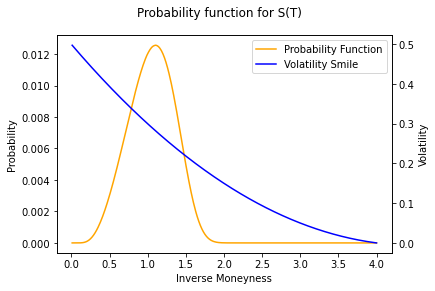

In [48]:
# This is how the derived probability function looks like

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt1=ax1.plot(mn,g,c='orange',label='Probability Function')
plt2=ax2.plot(mn,vols,c='b',label='Volatility Smile')
plts = plt1+plt2
labs = [l.get_label() for l in plts]
ax1.legend(plts, labs, loc='upper right')
fig.suptitle('Probability function for S(T)')
ax1.set_xlabel('Inverse Moneyness')
ax1.set_ylabel('Probability')
ax2.set_ylabel('Volatility')


Here we will define a function that makes the same process as we did before and directly plots the implicit probability function for S

In [49]:
def Get_Dist(spot, strike, step, r, T, a_, b_, c_, graph=""):
    """
    spot = spot price
    strike = maximum strike
    step = desired step
    r = risk free rate
    T = number of years
    a,b,c are the parameters that fit the volatility smile given the following equation:
    sigma(x)=ax^2+bx+c
    graph=graph if you want to plot the curve. It will give the DataFrame otherwise
    """
    # Create the strikes list
    
    strikes = []
    for sk in range(1, strike+1, step):
        strikes.append(sk)
    # Computing discount factor
    
    disc_f = 1/exp(r*T)
    
    # We add 2 values to the strike list: one in the beggining and one in the end
    
    first_v = strikes[0] - step
    last_v = strikes[-1] + step
    strikes.insert(0, first_v)
    strikes.append(last_v)
    n = len(strikes)
    
    # Then, we create the moneyness list
    
    mn = []
    for x in strikes:
        mn.append(x / spot)
    
    # Next, we create the volatility list
    
    vols = []
    for vol in mn:
        vols.append(a_*vol**2 +b_*vol + c_)
    
    # Call financepy functions for BS pricing
    
    valuation_date = Date(30, 11, 2021)
    expiry_date = valuation_date.add_years(T)
    discount_curve = DiscountCurveFlat(valuation_date, r)
    dividend_curve = DiscountCurveFlat(valuation_date, 0)
    
    # We, then, create the BS option price list
    
    BS = []
    _ = 0
    for bs in vols:
        Strike = strikes[_]
        call_option = EquityVanillaOption(expiry_date, Strike, OptionTypes.EUROPEAN_CALL)
        model = BlackScholes(bs)
        BS.append(call_option.value(valuation_date, S, discount_curve, dividend_curve, model))
        _ = _ + 1
    
    # Create probabilities list
    
    g = [0]

    for G in range(1, n-1):
        g.append((1/disc_f)*(BS[G + 1] - 2*BS[G] + BS[G - 1])/(step**2))
    g.append(0)
    
    # We create a dataframe with values
    df_smile = pd.DataFrame(columns=['Option Strike', 'Inverse Moneyness', 'Option Vol', 'Black Scholes', 'Density'])
    df_smile['Option Strike'] = strikes
    df_smile['Inverse Moneyness'] = mn
    df_smile['Option Vol'] = vols
    df_smile['Black Scholes'] = BS
    df_smile['Density'] = g
    
    df_smile.drop(df_smile.index[[0,-1]], inplace=True)
    
    # We readjust strikes list
    
    strikes.pop(0)
    strikes.pop(-1)    
    
    # Finally, we plot density
    if graph=="graph":
        plt.plot(df_smile['Inverse Moneyness'],df_smile['Density'])
        plt.title('Probability function for S(T)')
        plt.xlabel('Inverse Moneyness')
        plt.ylabel('Probability')
    else:
        return df_smile
    

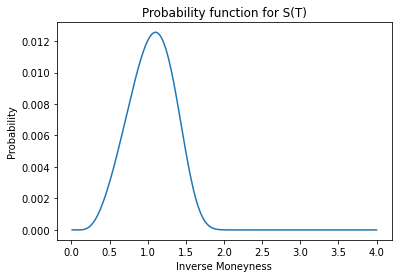

In [50]:
Get_Dist(100, 400, 1, 0.05, 1, 0.025, -0.225, 0.5, "graph")

### 3b. {-}

Now, using the derived probability function we will try to compute the price of a digital option. A digital option pays $\$1.00$ if $S(T)>K$. First, we well get the dataframe with the probability function we got above

In [51]:
df_density = Get_Dist(100, 400, 1, 0.05, 1, 0.025, -0.225, 0.5)

df_density

Option Strike  Inverse Moneyness  Option Vol  Black Scholes       Density
1                1               0.01    0.497752      99.048771 -1.015883e-12
2                2               0.02    0.495510      98.097541  3.286681e-13
3                3               0.03    0.493273      97.146312  1.874902e-11
4                4               0.04    0.491040      96.195082  3.431893e-10
5                5               0.05    0.488812      95.243853  3.035340e-09
..             ...                ...         ...            ...           ...
396            396               3.96    0.001040       0.000000  0.000000e+00
397            397               3.97    0.000772       0.000000  0.000000e+00
398            398               3.98    0.000510       0.000000  0.000000e+00
399            399               3.99    0.000252       0.000000  0.000000e+00
400            400               4.00    0.000000       0.000000  0.000000e+00

[400 rows x 5 columns]

With the probability density function we can compute the implied probabilities such that $Pr(S(T) < K)$. We can then create a table of probabilities for the stikes [60, 80, 100, 120, 140]

To compute the digital option price for a certain strike, we simply multiply the payoffs (1 or zero) by their respective probabilities. And then we multiply this expected payoff by the discount factor considering $r_{f}$ and $T$. This can be better understood by looking at the next equation for the value of a digital option:

$$V(S(0),t)=\mathrm{e}^{-r_{f}T}E[1_{S(T)>K}]$$

We will create a dataframe with the 'Strikes', 'Volatilities' and 'Digital Prices' for strikes [60, 80, 100, 120, 140]

In [52]:
# Creating list with digital option strike prices

digital_strikes = [60, 80, 100, 120, 140]

In [53]:
# We feed a list with the cummulative probabilities of each strike price

probabilities = []
for x in digital_strikes:
    probabilities.append(df_density.loc[df_density['Option Strike'] >= x, 'Density'].sum())

In [54]:
# We will then store the implied volatilities of each each strike price

volatilities = []

for z in digital_strikes:
    volatilities.append(df_density.loc[z, "Option Vol"])

In [55]:
# We will then create a dataframe with the results

df_digital = pd.DataFrame(columns = ['Strike', 'Volatility','Probabilities'])
df_digital['Strike'] = digital_strikes
df_digital['Volatility'] = volatilities
df_digital['Probabilities'] = probabilities

In [56]:
# We compute digital prices per strike price and add them as a new column

r=0.05
T=1
digital_prices = []

for z in df_digital.index:
    digital_prices.append(df_digital.iloc[z, 2]*exp(-r*T))
    
df_digital['Digital Price'] = digital_prices

df_digital

Strike  Volatility  Probabilities  Digital Price
0      60       0.374       0.927436       0.882205
1      80       0.336       0.792861       0.754193
2     100       0.300       0.582446       0.554040
3     120       0.266       0.334978       0.318641
4     140       0.234       0.129079       0.122784

### 3c. {-}

Now, we will compare this prices with the ones computed using the Black and Scholes formula. To compute the digital options BS price we will use financepy's EquityDigitalOption class and the formula used in class, which states that the value of a digital option can be computed as:

$$V(S(0),t)=\mathrm{e}^{-r_{f}T}N(d_{2})$$

Where:

$$d_{2}=-\Bigg[ \frac{ln(\frac{K}{S(0)})-(r-\frac{\sigma^{2}}{2})T}{\sigma\sqrt(T)} \Bigg]$$

In [57]:
from scipy.stats import norm

In [58]:
stock_price=100
r=0.05
T=1
digital_strikes = [60, 80, 100, 120, 140]

d_2=[]
BS_1=[]
for z in df_digital.index:
    k=df_digital.iloc[z, 0]
    vol=df_digital.iloc[z, 1]
    d_2.append(-(np.log(k/stock_price)-(r-0.5*vol**2)*T)/(vol*sqrt(T)))
    BS_1.append(norm.cdf(d_2[z])*exp(-r*T))

df_digital['d_2'] = d_2
df_digital['BS_1'] = BS_1

df_digital

Strike  Volatility  Probabilities  Digital Price       d_2      BS_1
0      60       0.374       0.927436       0.882205  1.312534  0.861176
1      80       0.336       0.792861       0.754193  0.644927  0.704398
2     100       0.300       0.582446       0.554040  0.016667  0.481939
3     120       0.266       0.334978       0.318641 -0.630449  0.251315
4     140       0.234       0.129079       0.122784 -1.341240  0.085536

Now, we will compute the price with the built-in function in financepy

In [59]:
valuation_date = Date(30, 11, 2021)
expiry_date = valuation_date.add_years(T)
discount_curve = DiscountCurveFlat(valuation_date, r)
dividend_curve = DiscountCurveFlat(valuation_date, 0)
underlying_type = FinDigitalOptionTypes.CASH_OR_NOTHING

In [60]:
# We compute prices for each strike and store them in a list

BS_prices = []

for z in df_digital.index:
    model = BlackScholes(df_digital.iloc[z, 1])
    digital_call = EquityDigitalOption(expiry_date, df_digital.iloc[z,0].astype(np.float64),OptionTypes.EUROPEAN_CALL, underlying_type)
    BS_prices.append(digital_call.value(valuation_date, stock_price, discount_curve, dividend_curve, model))

# Finally,we append the BS prices to our previous dataframe

df_digital['BS Prices'] = BS_prices

df_digital

Strike  Volatility  Probabilities  Digital Price       d_2      BS_1  \
0      60       0.374       0.927436       0.882205  1.312534  0.861176   
1      80       0.336       0.792861       0.754193  0.644927  0.704398   
2     100       0.300       0.582446       0.554040  0.016667  0.481939   
3     120       0.266       0.334978       0.318641 -0.630449  0.251315   
4     140       0.234       0.129079       0.122784 -1.341240  0.085536   

   BS Prices  
0   0.861176  
1   0.704398  
2   0.481939  
3   0.251315  
4   0.085536

### 3d. {-}

As can be observed in the data frame, the digital price calculated with the implied PDF from smile is always larger than the BS price. Since the implied stock price distribution is not exactly lognormal, as it is assumed under the BS framework, we cannot expect that the implied PDF prices the digital option correctly. We can understand this as if we were overstating the probability that the stock's price at maturity will end above the established strike. 

But even if the BS price is correct, the risk measures might not be as the volatility is assumed to not depend on the stock price. To better estiamate the risk measures, we would need to account for the change in value of the option as the volatility varies, since at different levels of $S(t)$ we have different volatilities, which should not be a constant function of the moneyness of the option or of the strike more specifically.


Considering the points mentioned above and that one of the advantages of the BS model is that it is not dependent on the real PDF of the stock price, we consider that the BS Prices are more correct.

### 3e. {-}

Finally, we will compute the price of a put option with $Strike=100$ but that only pays if the stock price falls below $ \$60.00$ at maturity. To do this we can define the value of the option as follows:

$$V(S(0),t)=\mathrm{e}^{-r_{f}T}max[K-S(T),0]E[1_{S(T)>\$60.00}]$$

This option can be understood as a Down-In option wiht strike of $\$100$ and barrier of $\$60.00$. We will price this using, first, our implied density function and then with the built-in function in financepy.

In [61]:
# We will create a new dataframe in which we will keep only the probability of the stock price
# going below the barrier level and we will compute the corresponding payoff
# We will, then, compute the present value of the expected payoff

Strike=100
probabilities_2 = []
stock_p = []
pay_off = []
for x in l:
    price=df_density.iloc[x-1,0]
    if df_density.iloc[x-1,0] <= 60:
        prob = df_density.iloc[x-1,4] # Filter the probabilities when the S(T) is above $60
        payoff_2 = Strike - price # Compute the payoff as the difference between the Strike and S(T)
    else:
        prob = 0
        payoff_2 = 0
    probabilities_2.append(prob)
    stock_p.append(price)
    pay_off.append(payoff_2)
    
df_put = pd.DataFrame(columns=['Stock Price (T)', 'Pay Off', 'Probability'])
df_put['Stock Price (T)'] = stock_p
df_put['Pay Off'] = pay_off
df_put['Probability'] = probabilities_2

df_put


Stock Price (T)  Pay Off   Probability
0                  1       99 -1.015883e-12
1                  2       98  3.286681e-13
2                  3       97  1.874902e-11
3                  4       96  3.431893e-10
4                  5       95  3.035340e-09
..               ...      ...           ...
395              396        0  0.000000e+00
396              397        0  0.000000e+00
397              398        0  0.000000e+00
398              399        0  0.000000e+00
399              400        0  0.000000e+00

[400 rows x 3 columns]

In [62]:
# Compute the present value of the expected payoff

exp_payoff = []
for x in l:
    expect_po = df_put.iloc[x-1,1]*df_put.iloc[x-1,2]
    exp_payoff.append(expect_po)
    
put_price=exp(-r*T)*sum(exp_payoff)

put_price

3.7631470428952696

In [63]:
# We define the common variables that we will be using to create the different options

valuation_date = Date(30, 11, 2021)
expiry_date = valuation_date.add_years(1)
num_observations=expiry_date-valuation_date
stock_price=100
r=0.05
T=1
stock_price = 100
strike_price = 100
volatility = df_density.iloc[strike_price-1,2]
interest_rate = 0.05
dividend_yield = 0.0
barrier_price = 60

model = BlackScholes(volatility)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

# We create three option objects, a Put, a Down-In Put and a Down-Out Put, and the Discount curves to value them

put_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_PUT)
put_value = put_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

barrierType = EquityBarrierTypes.DOWN_AND_IN_PUT
barrierOpt = EquityBarrierOption(expiry_date, strike_price, barrierType, barrier_price, num_observations)
barrier_put_in=barrierOpt.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

barrierType = EquityBarrierTypes.DOWN_AND_OUT_PUT
barrier_price = 60
barrierOpt = EquityBarrierOption(expiry_date, strike_price, barrierType, barrier_price, num_observations)
barrier_put_out=barrierOpt.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

# We create a Dataframe to show the results

Puts=[]
Puts = pd.DataFrame(columns=['Barrier DO Put Price', 'Barrier DO Put Price - BS', 'Barrier DI Put Price - BS', 'Put Price - BS'])
Puts.loc[0,'Barrier DO Put Price'] = put_price
Puts.loc[0,'Barrier DO Put Price - BS'] = barrier_put_in
Puts.loc[0,'Barrier DI Put Price - BS'] = barrier_put_out
Puts.loc[0,'Put Price - BS'] = put_value

Puts


Barrier DO Put Price Barrier DO Put Price - BS Barrier DI Put Price - BS  \
0             3.763147                  3.045652                  6.308535   

  Put Price - BS  
0       9.354187

With these values we can show that the values of the Down Out Put barrier option calculated with the implied density function are higher that the one suggested with the built-in function in financepy. One explanation for this is the volatiliy smile from where we got the implied density function, as it shifted the probability mass down. This means that given the market prices, the market is thinking that downard movements are more probable, probably overstating the probabilities of the stock's price being below the barrier level. 

In [64]:
put_value - barrier_put_in - barrier_put_out

3.019806626980426e-14

Finally, we can conclude that the sum of the values for a Down-In Put and a Down-Out Put add exatly to the value of a regular Put. 

# Question 4 - Modelling Volatility Skew {-}

### 4a. {-}

As we mentioned before, there is a problem with the Black and Scholes model regarding the risk measures as it does not account for the different levels for the volatility of the stock and its relationship with its price. To overcome this problem we can change the volatility in the model and substitute it with a stochastic volatility. One that depends on the stock. To show this, it might be good to start with a local model, which means that it depend on itself only. 

$$\frac{dS(t)}{S(t)}=(r-q)dt+\sigma(S)dW_{t}$$

Where $\sigma(S)$ is a determenistic function. We can compare this with the regular Black and Shcoles framework in which the relationship is as follows:

$$\frac{dS(t)}{S(t)}=(r-q)dt+\sigma_{BS} dW_{t}$$

One popular model is the Constant Elasticity of Variance which stablishes the following relationship:

$$\frac{dS(t)}{S(t)}=(r-q)dt+\sigma \Big(\frac{S(t)}{S(0)}\Big)^{\beta}dW_{t}$$

Then, in this case the deterministic function is:

$$\sigma(S)=\sigma \Big(\frac{S(t)}{S(0)}\Big)^{\beta}$$

This implies that when we have $\beta=0$, we recover the regular Black and Scholes framework. In this question, we will create a code to price a T-year european option based on Monte Carlo simulation so we can introduce this model. We will set $dt=0.02$ and implement antithetic variables to diminish the variance of our results. After solving our equation using Itto's lemma, we found that the solution for the stocasthic differential equation suggested first is:

$$S_{t+1}=S_{t}\mathrm{e}^{\Big[(\mu -\frac{\sigma_{BS new}^2}{2})dt+ \sigma_{BS new}dW_{t} \Big]}$$

Where:

$$\sigma_{BS new}=\sigma_{CEV}\Big(\frac{S_{t}}{S_{0}}\Big)^\beta $$

In [65]:
def mc_cev(stock_p, K, r, q, vol, t, number_steps_p_y, num_paths, seed, beta, opt_type="Call"):

    num_paths = int(num_paths)
    np.random.seed(seed)
    mu_2 = r - q
    dt = 1/number_steps_p_y
    vol_cev_1=[]
    FinalP_1 = []
    FinalP_2 = []
    Payoffs_1 = []
    Payoffs_2 = []
    
    # We recognize if we will be pricing a call or a put
    
    if opt_type=="Call":
        o=1
    else:
        o=-1
        
    # We generate the estimated final prices
    
    for i in range(0,num_paths):
        s_t_1=stock_p
        s_t_2=stock_p
        for j in range(0, int(number_steps_p_y*t)):
            g=np.random.randn()
            
            if j==0:
                vol_cev_1=vol
            else:
                vol_cev_1=vol*(s_t_1/stock_p)**beta
            s_t_1=s_t_1*exp((mu_2 - 0.5*(vol_cev_1**2))*dt + vol_cev_1*sqrt(dt)*g)
            
            # We generate an alternative path to use as an antithetic variable 
            
            if j==0:
                vol_cev_2=vol
            else:
                vol_cev_2=vol*(s_t_2/stock_p)**beta
            s_t_2=s_t_2*exp((mu_2 - 0.5*(vol_cev_2**2))*dt - vol_cev_2*sqrt(dt)*g)
            
        FinalP_1.append(s_t_1)
        FinalP_2.append(s_t_2)
    
    # We compute the estimated payoffs
    
    for k in range(0,num_paths):
        pay_o=o*(FinalP_1[k]-K)
        if pay_o>0:
             Payoffs_1.append(pay_o)
        else:
             Payoffs_1.append(0)
                
    for k in range(0,num_paths):
        pay_o=o*(FinalP_2[k]-K)
        if pay_o>0:
             Payoffs_2.append(pay_o)
        else:
             Payoffs_2.append(0)

    vol_cev_1=pd.DataFrame({'Final Prices_1':FinalP_1,
                       'Final Prices_2':FinalP_2,
                       'PayOff_1':Payoffs_1,
                              'PayOff_2':Payoffs_2})
    
    # We value the option as the discounted average expected payoff 
    
    discounted_payoff = np.mean([np.mean(vol_cev_1['PayOff_1']),np.mean(vol_cev_1['PayOff_2'])]) * np.exp(-r * t)
    
    return discounted_payoff

In [66]:
def mc_BS(stock_p, K, r, q, vol, t, number_steps_p_y, num_paths, seed, opt_type="Call"):

    num_paths = int(num_paths)
    np.random.seed(seed)
    mu_2 = r - q
    bs_m=[]
    FinalP_1 = []
    FinalP_2 = []
    Payoffs_1 = []
    Payoffs_2 = []
    
    dt = 1/number_steps_p_y
    
    # We recognize if we will be pricing a call or a put
    
    if opt_type=="Call":
        o=1
    else:
        o=-1
        
    # We generate the estimated final prices
    
    for i in range(0,num_paths):
        s_t_1=stock_p
        s_t_2=stock_p
        for j in range(0, int(number_steps_p_y*t)):
            g=np.random.randn()
            
            s_t_1=s_t_1*exp((mu_2 - 0.5*(vol**2))*dt + vol*sqrt(dt)*g)
            
            # We generate an alternative path to use as an antithetic variable
            
            s_t_2=s_t_2*exp((mu_2 - 0.5*(vol**2))*dt - vol*sqrt(dt)*g)
            
        FinalP_1.append(s_t_1)
        FinalP_2.append(s_t_2)
    
    # We compute the estimated payoffs
    
    for k in range(0,num_paths):
        pay_o=o*(FinalP_1[k]-K)
        if pay_o>0:
             Payoffs_1.append(pay_o)
        else:
             Payoffs_1.append(0)
                
    for k in range(0,num_paths):
        pay_o=o*(FinalP_2[k]-K)
        if pay_o>0:
             Payoffs_2.append(pay_o)
        else:
             Payoffs_2.append(0)

    bs_m=pd.DataFrame({'Final Prices_1':FinalP_1,
                       'Final Prices_2':FinalP_2,
                       'PayOff_1':Payoffs_1,
                              'PayOff_2':Payoffs_2})
    
    # We value the option as the discounted average expected payoff
    
    discounted_payoff = np.mean([np.mean(bs_m['PayOff_1']),np.mean(bs_m['PayOff_2'])]) * np.exp(-r * t)
    
    return discounted_payoff

In [67]:
mc_BS(100, 100, 0.05, 0, 0.2, 1, 50, 10000, 10, "Call")

10.504033406713246

In [68]:
mc_cev(100, 100, 0.05, 0, 0.2, 1, 50, 10000, 10, 0, "Call")

10.504033406713246

In [69]:
# We will compute the price using the BS model to test the accuracy

valuation_date = Date(30, 11, 2021)
expiry_date = valuation_date.add_years(1)
stock_price = 100
strike_price = 100
volatility = 0.20
interest_rate = 0.05
dividend_yield = 0.0
call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
model = BlackScholes(volatility)

call_value = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
print(call_value)

10.450575619322274


### 4b. {-}

Now, to better analyze the effect of the parameter $\beta$, we will price options with different strikes changing the value of the parameter $\beta$.

In [70]:
# Here, we initialize the common parameters of our options

s = 100
t = 0.5
r = 0.05
q = 0
v = 0.2
num_paths=10000
steps_y = 50
seed=9

valuation_date = Date(30, 11, 2021)
expiry_date = valuation_date.add_years(t)
discount_curve = DiscountCurveFlat(valuation_date, r)
dividend_curve = DiscountCurveFlat(valuation_date, q)
model = BlackScholes(v)


In [71]:
# We prepare the dataframe to store the results

l = []
for sk in range(80, 125,5):
    l.append(sk)
beta = [-0.5, -0.25, 0, 0.25, 0.5]
df_cev_t=pd.DataFrame(index=['80', '85', '90', '95', '100', '105', '110', '115', '120'],columns=['Beta = -0.5', 'Beta = -0.25', 'Beta = 0', 'Beta = 0.25', 'Beta = 0.5'])


In [72]:
# Here, we run the simulations for the varying values of the strike and the betas

m = 0
n= 0
for i in beta:
    n=0
    for j in l:
        call_option = mc_cev(s, j, r, q, v, t, steps_y, num_paths, seed, i, "Call")
        df_cev_t.iloc[n,m]=call_option
        n=n+1
    m=m+1

In [73]:
# Finally, we compute the corresponding Call price for each given strike

BS_P = []
leng = len(df_cev_t.index)
for a in range(0,leng):
    call_option = EquityVanillaOption(expiry_date, l[a], OptionTypes.EUROPEAN_CALL)
    call_value = call_option.value(valuation_date, s, discount_curve, dividend_curve, model)
    BS_P.append(call_value)

df_cev_t['BS_P'] = BS_P

df_cev_t

Beta = -0.5 Beta = -0.25   Beta = 0 Beta = 0.25 Beta = 0.5       BS_P
80    22.267162    22.239467  22.215334   22.194542  22.177004  22.154896
85    17.797871    17.757851  17.720287   17.685097  17.652215  17.628314
90    13.676006    13.635395  13.596369   13.558859  13.522799  13.469845
95    10.041982    10.016639    9.99234    9.969017   9.946729   9.840506
100    7.004435     7.007224   7.011142    7.016185   7.022323   6.855316
105    4.631343     4.667105   4.704207    4.742656   4.782532   4.550021
110    2.897465      2.95797   3.020136    3.083836   3.149368   2.879009
115    1.705148     1.777474   1.852331    1.929819   2.010097   1.739637
120    0.938678      1.00915   1.083259    1.161176   1.243088   1.006317

Quite interestingly, we can see that the differences in the prices, as the $\beta$ varies, are larger when the strike moves far from $S_{0}$. And it seems that the differences are larger when the strikes are tilted to the upside. 

### 4c. {-}

Now, given the prices we obtained earlier, we will try to derive the volatility smile corresponding to each value of $\beta$

In [74]:
from financepy.utils.global_vars import gDaysInYear
from financepy.models.black_scholes_analytic import bs_implied_volatility

In [75]:
# We prepare the dataframe to store the implied volatilities

df_cev_iv=pd.DataFrame(index=['80', '85', '90', '95', '100', '105', '110', '115', '120'],columns=['Beta = -0.5', 'Beta = -0.25', 'Beta = 0', 'Beta = 0.25', 'Beta = 0.5', "B&S"])
m = 0
n= 0
beta.append('B&S')

# Using the Financepy built-in function, we derived the implied volatility for each value of K and beta
for i in beta:
    n=0
    for j in l:
        call_option = EquityVanillaOption(expiry_date, j, OptionTypes.EUROPEAN_CALL)
        Implied_volatility = call_option.implied_volatility(valuation_date, s, discount_curve, dividend_curve,  df_cev_t.iloc[n,m])
        df_cev_iv.iloc[n,m]=Implied_volatility
        n=n+1
    m=m+1


df_cev_iv

Beta = -0.5 Beta = -0.25  Beta = 0 Beta = 0.25 Beta = 0.5  B&S
80     0.218665     0.214469  0.210624    0.207147   0.204077  0.2
85     0.215115     0.211704  0.208421    0.205268   0.202246  0.2
90     0.211752     0.209479  0.207276    0.205141   0.203071  0.2
95     0.208591     0.207516  0.206483    0.205491   0.204542  0.2
100     0.20547     0.205572  0.205716    0.205901   0.206126  0.2
105    0.202909     0.204188  0.205514    0.206889   0.208314  0.2
110     0.20072     0.203077  0.205493    0.207961   0.210492  0.2
115    0.198374     0.201774  0.205253    0.208817    0.21247  0.2
120    0.195774     0.200175  0.204676    0.209286    0.21401  0.2

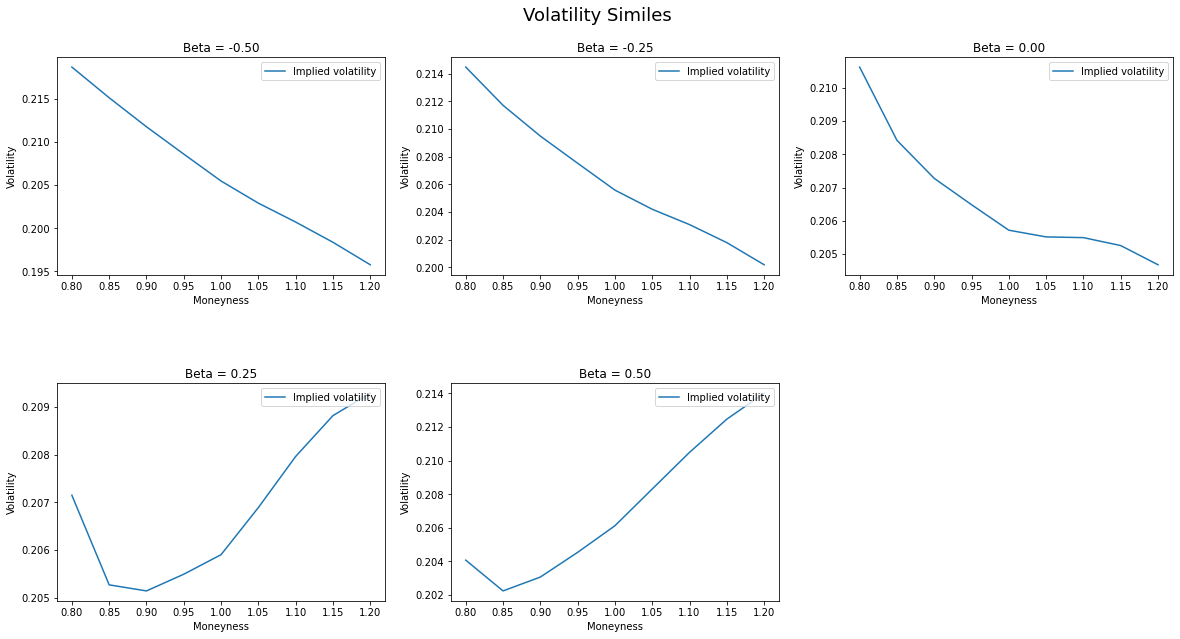

In [76]:
# Here, we create the graphs to analyze the results

cols = ['Beta = -0.50', 'Beta = -0.25', 'Beta = 0.00', 'Beta = 0.25', 'Beta = 0.50', 'B&S']
inv_mn=[]
for f in l:
    invmn = f/s
    inv_mn.append(invmn)
df_cev_iv2 = df_cev_iv
df_cev_iv2.index = inv_mn

plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Volatility Similes", fontsize=18, y=0.95)

for n in range(0,len(beta)-1):
    # We add a new subplot iteratively
    
    ax = plt.subplot(2, 3, n + 1)
    df_cev_iv2.iloc[:,n].plot(ax=ax, label="Implied volatility")
    ax.set_title(cols[n])
    ax.legend(loc="upper right")
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Volatility")

As we can see, when beta is positive, the relationship between the strike and the volatility changes to an upward sloping curve. This implies that expectations for the volatility are higer at higher prices. This is consistent with our model, as with a positive $\beta$, as the stockprice goes up, so does the volatility used to feed the model. It is important to note that as $\beta$ gets more negative, the curve gets more steeper. Same happens when $\beta$ increases. In the case of $\beta=0$, we should be looking at a straight line given that in that case we are under the Black and Scholes framework with the volatility being fixed. Nonetheless, as the Monte Carlo simulation adds some error to the computed prices, the implied volatility is not exactly the 0.20% that we used, but is pretty close.

### 4d. {-}

Finally, we will try to estimate the deltas for our models given the different values of $\beta$ and $K$. Given that the volatility is no longer constant, we need to add an additional adjustment to our delta estimation. This would look as follows:

$$\Delta=\frac{\delta V}{\delta S}\Big|_{\sigma_{BS}} + \frac{\delta V}{\delta \sigma_{BS}}\frac{\delta \sigma_{BS}}{\delta S}$$

Which can be rewritten as:

$$\Delta=\Delta_{BS} + \nu_{BS}\frac{\delta \sigma_{BS}}{\delta S}$$

We can compute the delta and the vega using the built-in financepy formulas. For the last term, it refers to the slope of the volatilites smiles. We can estimate it by changing the stock price by $\$0.1$ and recomputing the Call price. Finally, we recover the implied volatilityes for the new prices and estimate the slopes of the curves as follows:

$$\frac{\delta \sigma_{BS}}{\delta S}=\frac{\sigma_{BS}^{new}-\sigma_{BS}^{original}}{S^{new}-S^{original}}$$

In [77]:
# We prepare the dataframe to store the results

df_cev_t_2=pd.DataFrame(index=['80', '85', '90', '95', '100', '105', '110', '115', '120'],columns=['Beta = -0.5', 'Beta = -0.25', 'Beta = 0', 'Beta = 0.25', 'Beta = 0.5'])

In [78]:
# Here, we run the simulations for the varying values of the strike and the betas and
# we change the value of S as well

s2=s+0.1
beta2 = [-0.5, -0.25, 0, 0.25, 0.5]

m = 0
n= 0
for i in beta2:
    n=0
    for j in l:
        call_option = mc_cev(s2, j, r, q, v, t, steps_y, num_paths, seed, i, "Call")
        df_cev_t_2.iloc[n,m]=call_option
        n=n+1
    m=m+1

In [79]:
# Finally, we compute the corresponding Call price for each given strike

BS_P = []
leng = len(df_cev_t.index)
for a in range(0,leng):
    call_option = EquityVanillaOption(expiry_date, l[a], OptionTypes.EUROPEAN_CALL)
    call_value = call_option.value(valuation_date, s2, discount_curve, dividend_curve, model)
    BS_P.append(call_value)

df_cev_t_2['BS_P'] = BS_P

df_cev_t_2

Beta = -0.5 Beta = -0.25   Beta = 0 Beta = 0.25 Beta = 0.5       BS_P
80    22.363039    22.335618  22.311728   22.291227  22.273975  22.251566
85    17.889119    17.849161  17.811696   17.776625   17.74392  17.720297
90    13.760063    13.719257  13.680066   13.642411  13.606221  13.553933
95    10.115796    10.089984  10.065288   10.041564  10.018848   9.913552
100    7.065894     7.067984   7.071282    7.075668   7.081153   6.915188
105    4.679052     4.714258   4.750738    4.788554     4.8278   4.596181
110    2.932393     2.992624   3.054373    3.117771   3.182877   2.912489
115    1.728944     1.801184   1.875949    1.953351   2.033545   1.762532
120    0.953977     1.024688    1.09899    1.177108   1.259188   1.021130

In [80]:
# We prepare the dataframe to store the implied volatilities

df_cev_iv2=pd.DataFrame(index=['80', '85', '90', '95', '100', '105', '110', '115', '120'],columns=['Beta = -0.5', 'Beta = -0.25', 'Beta = 0', 'Beta = 0.25', 'Beta = 0.5', "B&S"])
m = 0
n= 0
beta2.append('B&S')

# Using the Financepy built-in function, we derived the implied volatility for each value of K and beta
for i in beta2:
    n=0
    for j in l:
        call_option = EquityVanillaOption(expiry_date, j, OptionTypes.EUROPEAN_CALL)
        Implied_volatility = call_option.implied_volatility(valuation_date, s2, discount_curve, dividend_curve,  df_cev_t_2.iloc[n,m])
        df_cev_iv2.iloc[n,m]=Implied_volatility
        n=n+1
    m=m+1


df_cev_iv2

Beta = -0.5 Beta = -0.25  Beta = 0 Beta = 0.25 Beta = 0.5  B&S
80     0.218729     0.214535  0.210691    0.207228   0.204178  0.2
85     0.215171      0.21174   0.20844    0.205271    0.20224  0.2
90     0.211817      0.20952  0.207295     0.20514   0.203051  0.2
95     0.208651     0.207552    0.2065    0.205487   0.204517  0.2
100    0.205532     0.205609   0.20573    0.205891   0.206092  0.2
105    0.202959     0.204216  0.205518    0.206868   0.208268  0.2
110    0.200774     0.203111    0.2055    0.207947   0.210454  0.2
115    0.198427     0.201801  0.205255    0.208793   0.212422  0.2
120    0.195841     0.200217  0.204693    0.209278   0.213977  0.2

In [81]:
# We prepare the dataframe to store the new deltas

df_cev_delta=pd.DataFrame(index=['80', '85', '90', '95', '100', '105', '110', '115', '120'],columns=['Beta = -0.5', 'Beta = -0.25', 'Beta = 0', 'Beta = 0.25', 'Beta = 0.5', "B&S"])
m = 0
n= 0
beta2.append('B&S')

# Using the Financepy built-in function, we derived the implied volatility for each value of K and beta
for i in beta:
    n=0
    for j in l:
        call_option = EquityVanillaOption(expiry_date, j, OptionTypes.EUROPEAN_CALL)
        call_delta=call_option.delta(valuation_date, s, discount_curve, dividend_curve, model)
        call_vega=call_option.vega(valuation_date, s, discount_curve, dividend_curve, model)
        call_delta2 = call_delta+call_vega*(df_cev_iv2.iloc[n,m]-df_cev_iv.iloc[n,m])/(s2-s) # We implement the adjustment suggested at the begining of the question

        df_cev_delta.iloc[n,m]=call_delta2
        n=n+1
    m=m+1


df_cev_delta

Beta = -0.5 Beta = -0.25  Beta = 0 Beta = 0.25 Beta = 0.5       B&S
80     0.969766      0.96989  0.969972    0.970729   0.971756  0.966439
85     0.925239     0.923105  0.921282    0.919666   0.918641  0.919304
90     0.851004     0.847073  0.843414    0.839914   0.836546  0.840025
95     0.743289     0.737877  0.733196     0.72848    0.72351   0.72929
100     0.61432     0.607352  0.601185    0.594651   0.588162   0.59734
105    0.474298     0.468164   0.46134    0.454412   0.447494  0.460189
110    0.347176     0.342045  0.335495    0.330107   0.323527  0.333502
115    0.239064     0.233599  0.228182    0.222913   0.217769  0.227869
120    0.158196     0.154258  0.150023    0.146054   0.141912  0.147303

In [82]:
df_cev_iv2

Beta = -0.5 Beta = -0.25  Beta = 0 Beta = 0.25 Beta = 0.5  B&S
80     0.218729     0.214535  0.210691    0.207228   0.204178  0.2
85     0.215171      0.21174   0.20844    0.205271    0.20224  0.2
90     0.211817      0.20952  0.207295     0.20514   0.203051  0.2
95     0.208651     0.207552    0.2065    0.205487   0.204517  0.2
100    0.205532     0.205609   0.20573    0.205891   0.206092  0.2
105    0.202959     0.204216  0.205518    0.206868   0.208268  0.2
110    0.200774     0.203111    0.2055    0.207947   0.210454  0.2
115    0.198427     0.201801  0.205255    0.208793   0.212422  0.2
120    0.195841     0.200217  0.204693    0.209278   0.213977  0.2

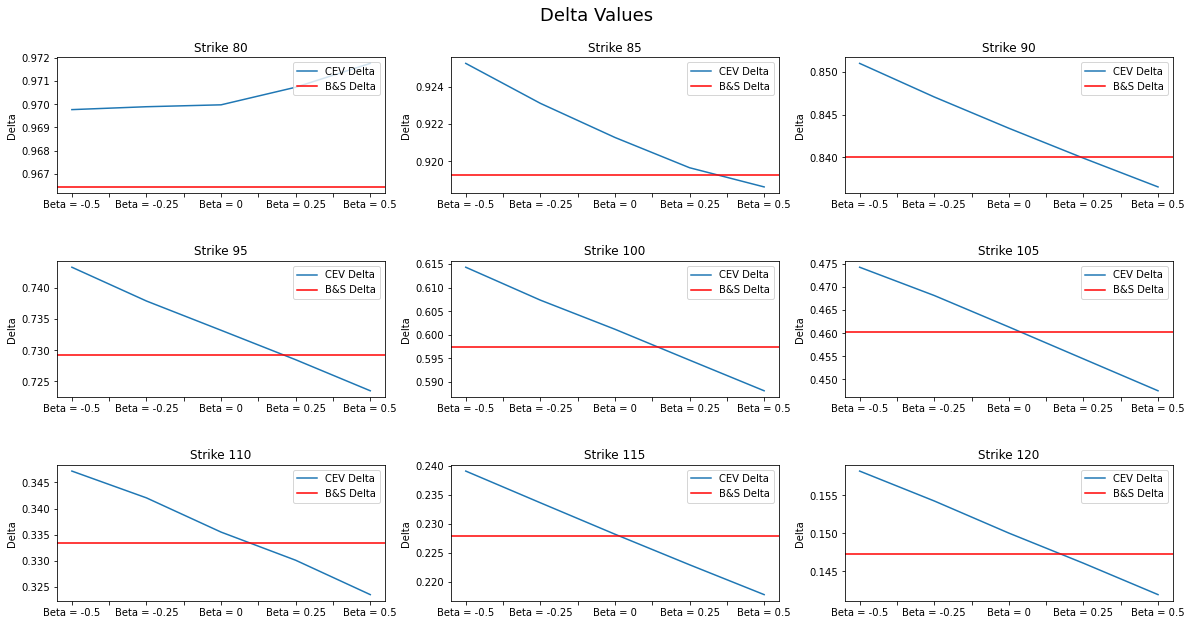

In [83]:
df_cev_delta2=df_cev_delta.drop('B&S', axis=1)

plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Delta Values", fontsize=18, y=0.95)

for n in range(0,len(l)):
    # We add a new subplot iteratively
    
    ax = plt.subplot(3, 3, n + 1)
    m=0
    df_cev_delta2.iloc[n,0:len(beta2)].plot(ax=ax, label="CEV Delta")
    plt.axhline(y=df_cev_delta.iloc[n,5], color='r', label="B&S Delta")
    ax.set_title('Strike '+str(l[n]))
    ax.legend(loc="upper right")
    ax.set_ylabel("Delta")


As we can see, as the value of $\beta$s increases the option total sensitivity to changes in the stock price slightly decreases. This makes sense as the volatility skew observed above gets inverted for positive and higher $\beta$s. One could understand this as if the vega exposure of the option actually changed the sign. For a skewed volatility curve like the ones we can see when $\beta$ is negative, the vega of an option is positive. So, when the curve gets inverted, it makes sense to think as if the vega now will be negative. This detail makes the adjustment made to the option delta yield lower sensitivities when the $\beta$ is positive.

# Question 5 - Variance Swaps {-}

### 5a. {-}

In this question we will explore how Variance Swaps work and how can we hedge a Variance Swap. The first thing to notice is that the variance in this context is computed as follows:

$$\sigma^{2}=\frac{252}{N}\sum^{N}_{i=1}\Big(ln\Big(\frac{S_{i}}{S_{i-1}}\Big)\Big)^{2}$$

Next, we will introduce the general idea behind a variance swap. A variance swap is a pure volatility trade whose payoff is the difference between the strike and the realized volatility. So:

$$V_{Swap}=Notional\cdot(\sigma_{Realized}^{2}-\sigma_{Strike}^{2})$$

It is useful to notice that the realised variance of an underlying through some period of time can be replicated with a portfolio consisting of two parts. First, a dynamic portfolio which we will be calling the Dynamic Hedge and will consist on $\frac{2}{T}$ times $\frac{1}{S_{t}}$ shares of the stock:

$$DynamicHedge = \frac{2}{T}\frac{1}{S_{t}}$$

And a static portfolio, which will be called Static Hedge, such that:

$$StaticHedge = \frac{2}{T}logcontract$$

Where the logcontract payoff is based on the total appreciation or depreciation of the stock. Interestingly, it can be shown that forming a portfolio of a long Dynamic Hedge and short the Static Hedge allow us to replicate rather closely the realized variance of the underlying. Along some period of time, the value of the realized variance is: 

$$V =\frac{2}{T}\Big[\int^{T}_{0} \frac{dS_{t}}{S_{t}}-ln\frac{S_{t}}{S_{0}}\Big]$$

We, will try to show this in this question. First, we will create a function to simulate the evolution of the Dynamic Hedge portfolio and, next, we will combine this with a short position in the logcontract described above. The first step into our analysis will be to create a function to simulate the one path of the evolution of a stock assuming it follows a lognormal process. This means that:

$$S_{t+1}=S_{t}\mathrm{e}^{\Big[(\mu -\frac{\sigma^2}{2})dt+ \sigma dW_{t} \Big]}$$



In [84]:
# This function will allow us to simulate one path for the stock

def logNormal_path(S0, mu, sigma, T, M):
    dt = float(T) / M
    rn = np.random.standard_normal(M + 1)
    path = S0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rn))
    path = pd.DataFrame(path, columns=['Path'])
    path=path.shift(1)
    path.Path[0] = S0
    return path

In [85]:
# Here, we will define the default values for our simulation and obtain the simulated value

S0 = 100
mu = 0.05
sigma = 0.3
M = 252
T = 1

S = logNormal_path(S0, mu, sigma, T, M)

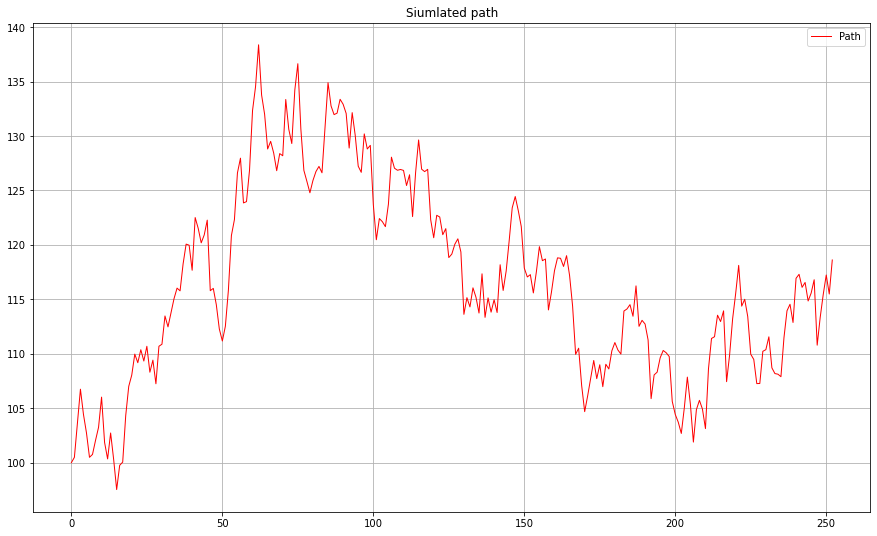

In [86]:
# Here, we present a graph with the simulated path

S.plot(figsize=(15, 9), title='Siumlated path', color = 'red', linewidth=1.0, grid=True)
plt.legend()
plt.show()

In [87]:
# Here, we create a function to compute the total proceeds of the Dynamic Hedging porftolio. At each day you have
# 1/s(t) stocks and you buy at s(t) and sell at s(t+1). The total proceeds per day of such strategy is (s(t+1)-s(t))/s(t)

def dynamic_hedge(path):
    dh = ((path - path.shift(1))/path.shift(1))
    dh.dropna(inplace = True)
    return (2/T) * dh['Path'].sum()

In [88]:
# Here, we compute the total proceeds of the Static Heding portfolio. This component is based on a logcontract that pays the log of  
# the total appreciation of the underlying.

def static_hedge(path):
    St = path['Path'].values.tolist()
    return (2/T) * np.log(St[-1]/St[0])

In [89]:
# This is a function to calculate the realised variance for every path generated

def realized_var(path):
    log_ret = np.log(path/path.shift(1))
    log_ret.dropna(inplace = True)
    return (252/log_ret.shape[0]) * (log_ret['Path'].pow(2)).sum()

Now, we will compare the value of the portfolio comprising of a long position on the Dynamic Hedge and short the Static Hedge to see how well our portfolio replicates the realized volatility.

In [90]:
Hedge = dynamic_hedge(S)-static_hedge(S)
Real_Var = realized_var(S)

Hedge**0.5

0.3294704495294486

In [91]:
Real_Var**0.5

0.329631300432506

In [92]:
error=Hedge**0.5-Real_Var**0.5
error

-0.0001608509030573968

As we can see, our portfolio does a pretty good job in replicating the realized volatility. Now, we will simulate 1,000 differents paths to simulate the final Payoff of a variance 1 year swap with strike of 30% that has been hedged dynamically. This means that we will sell the swap and try to hedge the position by going long the replicating portfolio. On average, the final payoff should be equal to the square of the strike, as the payoffs are based on the variance and not on the volatility. 

### 5b. {-}

Next, we will test how well does the portfolio consisting on the Dynamic Hedge position and the Statig Hedge position can help use to hedge a Variance Swap. In theory, a hedged swap payoff should by pretty close to the variance swap payoff as the realized variance exposure is hedged away.

In [93]:
def simulations(N, S0, mu, sigma, T, M):
    PLs = []
    for i in range(N):
        S = logNormal_path(S0, mu, sigma, T, M)
        V = dynamic_hedge(S) - static_hedge(S)
        PL = - realized_var(S) + sigma**2 + V
        #print(PL)
        PLs.append(PL)
    PLs = np.array(PLs)
    plt.figure(1)
    plt.hist(PLs, bins = 100, density=False)
    plt.title('30% 1 year Hedged Variance Swap final Payoff')
    #plt.legend()
    plt.show()
    #return PLs

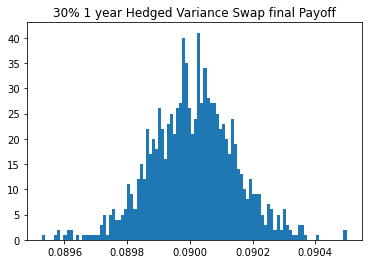

In [94]:
simulations(1000, S0, mu, sigma, T, M)

In [95]:
Strike=0.30
Strike**2

0.09

As we can see, the final payoff is very close to the strike in all the simulations, which suggest that the hedge works very well not only on average but all along all the paths. 

# Question 6 - Swaption Pricing {-}

In this question, we will go through the process to compute the value of a swaption. We will explain all the process behind and show the results we obtained in excel.

In [1]:
from PIL import Image

In [2]:
# We assign a variable to each of the images we will be using

img_a_1 = Image.open('Q6_images/ex_a_1.png')
img_a = Image.open('Q6_images/ex_a.png')
img_b = Image.open('Q6_images/ex_b.png')
img_c_d_cashflow = Image.open('Q6_images/ex_c_d_cashflow.png')
img_c_d_results = Image.open('Q6_images/ex_c_d_results.png')
img_e_results = Image.open('Q6_images/ex_e_results.png')

### 6a. {-}

The first step we need to value a swaption is to have the discount factors that fit exactly the fixed swap rates observed in the market. To to this we follow the next reasoning. We can think as each swap rate to be the coupon rate of a bond paying semiannual payments. 

As a swap rate is valued zero at inception, this is the same as saying that the hypothetical bond is priced at par. This means that the discount rates are such that, for the given coupon rates (swap rates), all the possible bonds are priced at par. In an equation, this means that:

$$S(t,T)\sum_{i=1}^{N}\Delta_{i}Z(t,t_{i})+Z(t,T)=1$$

This can be represented as a matrix operation as follows:

$$S\cdot Z = \begin{pmatrix}1\\
1 \\
. \\
. \\
1 
\end{pmatrix}$$

Where $S$ is a matrix containing all the cashflows for the hypotetical bonds and $Z$ is the column vector of discount factors. Given, that we now have all the cashflows, we can solve for the discount factors. This is what we did in this first part of the question. First, we replicated the excel sheet we viewed in class.

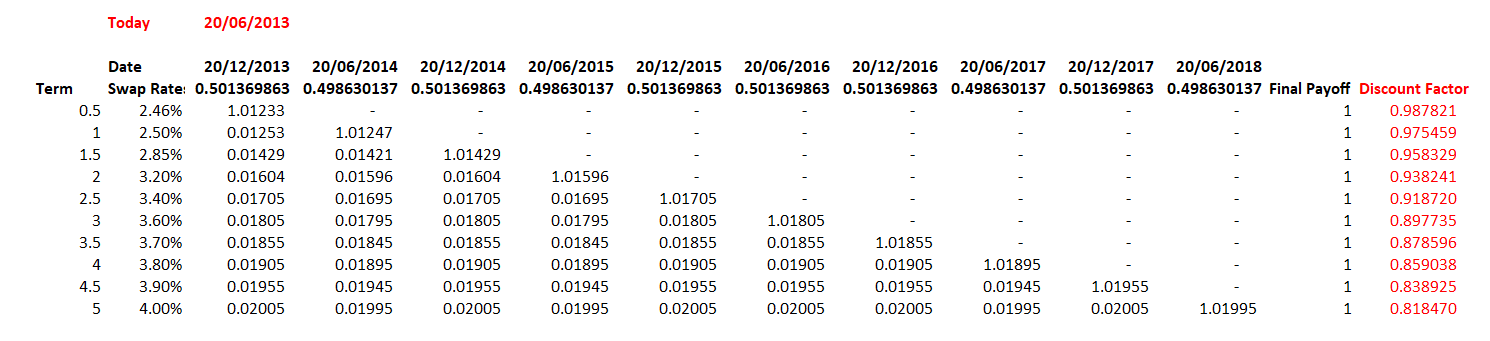

In [3]:
img_a_1

Then we modified this to create a template for a 10 years swap curve. You will find below the Swap sheet screenshot that we built in excel, with defined rates for 1, 2, 3, 5, 7, 10 years tenor. We used the following assumptions to construct the cashflow shcedule:

- The coupon payment conventions for the fixed leg is Act / 360
- The Swap Rate is flat at 5% - which leads to interpolated rates of 5% between defined maturities
- We assumed $t_{0}$ as 08/12/2021

By performing the a matrix operation we derived the following discount factors

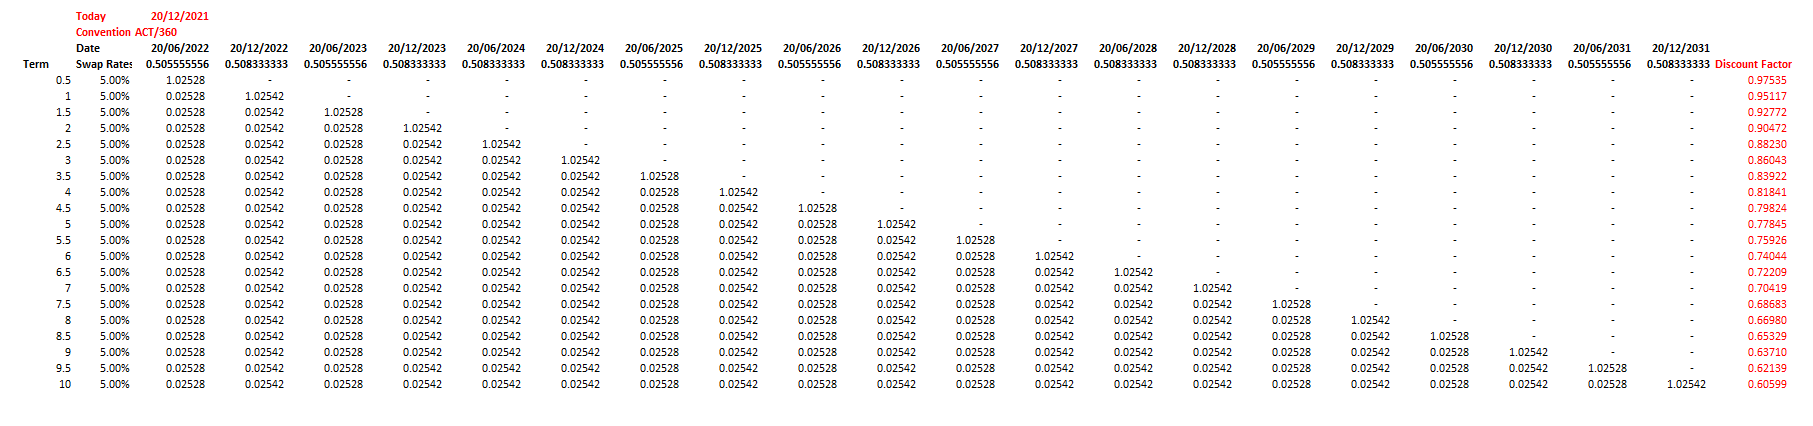

In [4]:
img_a

### 6b. {-}

Next, we will use the above templeate to retrieve the discount factors that fit the following swap curve:

- 1Y: 2.30%
- 2Y: 2.60%
- 3Y: 2.86%
- 5Y: 3.03%
- 7Y: 3.18%
- 10Y: 3.25%

Below you will find the screenshot of the Excel Swap sheet with the requested inputs. The rates and terms in blue are interpolated values. The ones in black are pre-defined.You can see the final discount factor curve in the last column of the image.

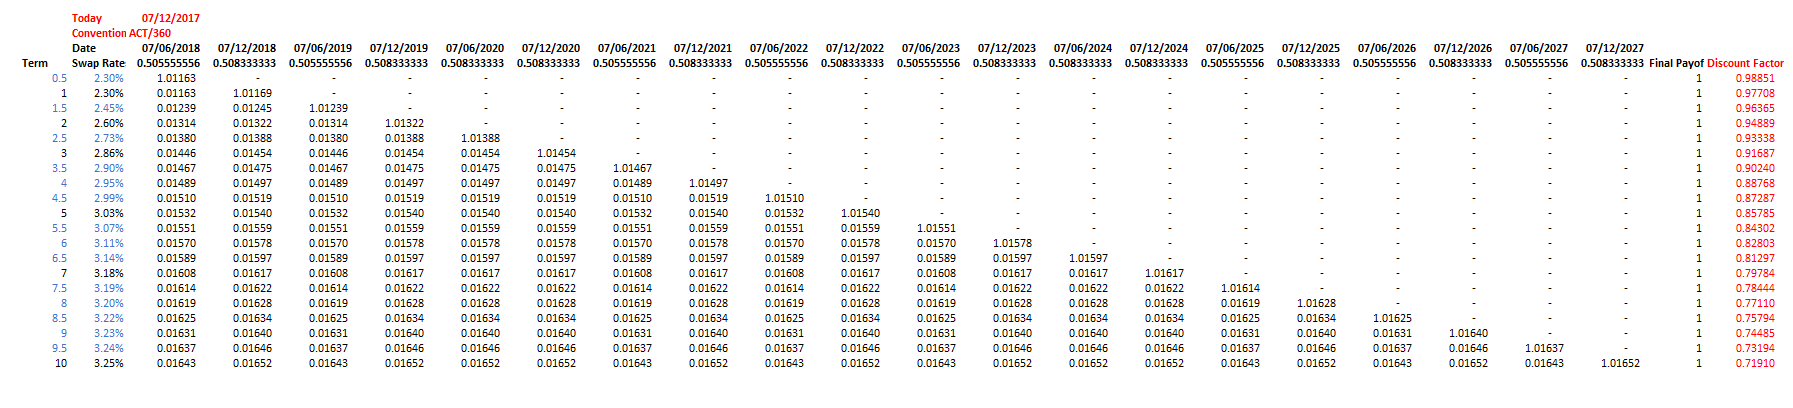

In [5]:
img_b

### 6c. and 6d. {-}

For the next to question, we used the above excersice to value  a 1x7 swaption for both the receiver and the payer leg. To simplify the visualisation of the results, we merged the answer from 6c and 6d into the same spreadsheet. To valuate the swaption, we used the same inputs from questions a and b in both questions. Besides we also took the following main assumptions:

- Rates: 
    - 1Y: 2.3%
    - 2Y: 2.6%
    - 3Y: 2.86% 
    - 5Y: 3.03%
    - 7Y: 3.18%
    - 10Y: 3.25%
- Interpolation method: Linear
- Day count convention: Act / 360
- Valuation date: 07/12/2017
- Notional: 1.000.000,00 euros
- 1 year optionality
- 7 years maturity starting today
- Fixed leg payments: semi-annual

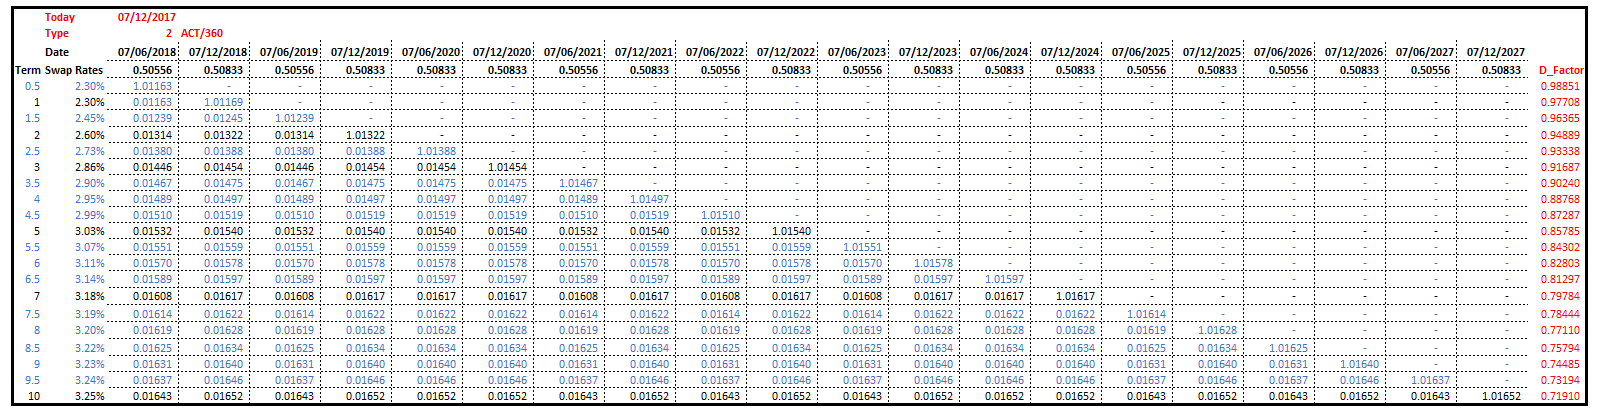

In [6]:
# Cashflow and discount factor curve:

img_c_d_cashflow

To value the swaption, the first thing we need to find is the forward swap rate. This rate is the rate that will make the future swap to be worth zero at inception. It is defined as:

$$ F = \frac {Z(0,T)-Z(0,t_{n})}{A(0,T,t_{n}}$$

Where $Z(0,T)$ and $Z(0,t_{n})$ are the discount factors for the date in which the swap begins and at which it matures. On the other hand, $A(0,T,t_{n})$ is the sum of discount factors, adjusted by their corresponding year fraction, between both dates. Once we have the forward swap rate, we can find the value of both legs of the swap as follows:

$$V_{Payer}=A(0,T,t_{n})\times E[F_{0}\Phi(d_{1})-K\Phi(d_{2})]$$

$$V_{Receiver}=A(0,T,t_{n})\times E[K\Phi(-d_{2})-F_{0}\Phi(-d_{2})]$$

Where:

$$d_{1}=\frac{ln\Big(\frac{F_{0}}{K}\Big)+\frac{\sigma^{2}}{2}T}{\sigma \sqrt{T}}$$

$$d_{2}=d_{1}-\sigma \sqrt{T}$$

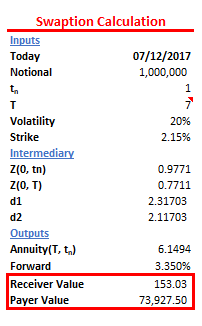

In [7]:
# Results:

img_c_d_results

Comentaries on answers for C and D:

1. Z(0, $t_{n}$) is the discount factor until the expiry date of the option.
2. Z(0, T) is the discount factor untiy the maturity of the swap.
3. The forward rate is referred as 'Forward' in the image.
4. The swap PV01 is referred as Annuity(T, tn).
5. 'Receiver Value' and 'Payer Value' are self-explanatoy. They are the result considering all the inputs shown in the image.

### 6e. {-}

Finally, we will look at the exposure of both the receiver and the payer at each point of the yield curve that we were given initially. To do this, we changed by 1bps each swap rate at a time and we recorded the value changes in the table below.

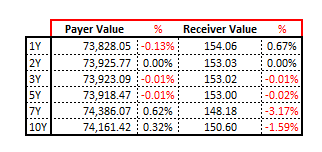

In [8]:
# In the image below you will see the pricing results when we add 1bp to every pre-defined swap rate:

img_e_results

As we can see in the image above, the swap risk are concentrated in the 1, 7 and 10 years market swap rate. This makes sense as the expiration of the option on the swap is on the first year and the maturity of the embedded swap is on the 8th year, whose swap rate was found by interpolating the 7 and 10 years swap rates. In reality, a swap is exposed to all the swap curve before expiry  as the discount factors will change. But, given the formula of the forward swap rate that we illustrated above it makes sense to expect a higher exposure to those discount factors coinciding with the expiry of the option and the future swap contract. In this regard, one could hedge this risk by entering in an offseting IRS position on those specifics maturities. The amount of each hedging swap will be definded by the ratio of sensitivites of the hedging swap and the original swap to that key swap rate. In the case of the 1 year hedging swap, the hedge might need to be done dynamically given the price dynamics of the embedded option. 

# Question 7 - CDS Valuation and Risk {-}

Now, in this question, we will go through the process on how to value a Credit Default Swap. We will explain all the process behind and show the results we obtained in excel.

In [9]:
# We assign a variable to each of the images we will be using

img_7a = Image.open('Q7_images/CDS model calibration.png')
img_7b = Image.open('Q7_images/CDS Problem b.png')
img_7c = Image.open('Q7_images/CDS Problem c.png')
img_7d = Image.open('Q7_images/CDS Problem d.png')
img_7e = Image.open('Q7_images/CDS Problem e.png')
img_7f = Image.open('Q7_images/CDS Problem f.png')

### 7a. {-}

The first step to value a CDS is to recover the hazard rates that fit exactly the CDS spreads quoted in the market. To do this we need to go through several concepts. First, we need to understand that in a CDS there is a leg offering the protection and a leg paying a premium to get that protection. The value of each leg are degined as follow:

$$Premium Leg PV = C \sum_{n=1}^{N}\Delta_{n}Q(t_{n})Z(t_{n})$$

$$Protection Leg PV = (1-R)\int_{0}^{T}Z(t)(-dQ(t))$$


Where:

- $C$ is the premium paid for the protection
- $\Delta_{n}$ is the fraction of the year for that coupon payment
- $Q(t_{n})$ is the probability of no default until time $t_{n}$
- $Z(t_{n})$ is the discount factor
- $R$ is the recovery rate (usually assumed to be equal to 40%)
- $-dQ(t)$ is the probability of default between two small points of time $t_{n}$ and $t_{n+1}$

At any given point in time, it must hold that:

$$PV of Protection Leg=C\cdot RPV01$$

Where:

$$RPV01=\sum_{n=1}^{N}\Delta_{n}Q(t_{n})Z(t_{n})$$

Here, $RPV01$ represents the Risky Present Value of $\$1.00$. This means that it is the the Present Value of $\$1.00$ accounting for the probability that its payment is contingent on the reference entity not defaulting. Then, we can find the CDS Spread as:

$$C=\frac{PV of Protection Leg}{RPV01}$$

Knowing this, we can calibrate a model to construct a CDS spread curve and from there get the value at any moment of any CDS. The only thing that we need to get is the probability of not defaulting. The way to do this is to define such probability as follows:

$$Q(0,T)=exp^{-\int_{0}^{T}h(s)ds}$$

Where $h(s)$ is defined as the hazard rate. A market convention is to set the hazard rate to be piecewise flat. It means that it is constant between the quoted CDS spread. This allow us to compute the probability of default at any given point and, therefore, to construct the CDS spread term. Folowing this idea, we replicated the excel sheet we viewed in class. The calibration is done by using Solver

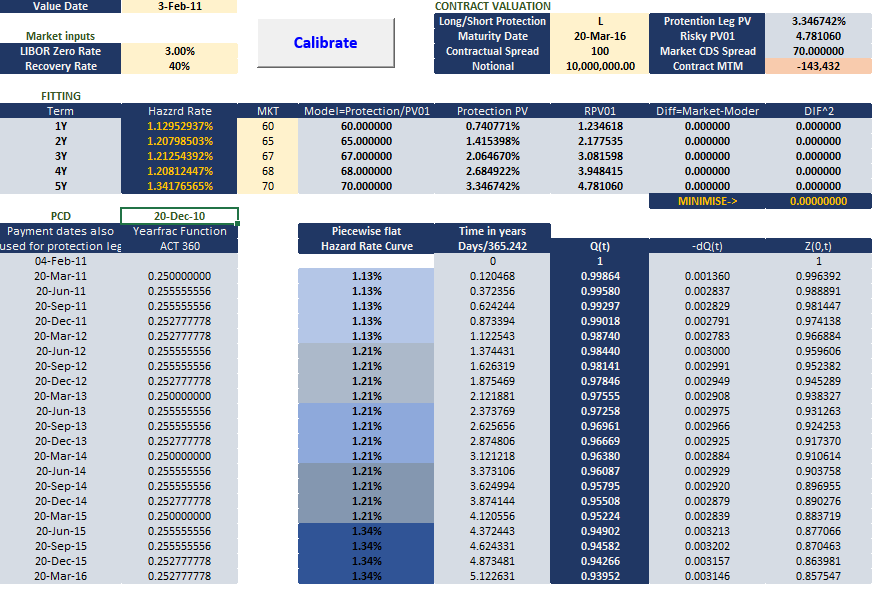

In [10]:
img_7a

Then we modified this to create a template for a 10 years swap curve. You will find below the Swap sheet screenshot that we built in excel, with defined rates for 1, 2, 3, 5, 7, 10 years tenor. We used the following assumptions to construct the cashflow shcedule:

- The coupon payment conventions for the fixed leg is Act / 360
- The Swap Rate is flat at 5% - which leads to interpolated rates of 5% between defined maturities
- We assumed t0 as 08/12/2021

By performing the a matrix operation we derived the following discount factors

### 7b. {-}

Next, we will use the above templeate to retrieve the term strucutre of hazard rates and survival probabilites given the following points on the CDS curve on the 8th December 2017:

- 1Y: 65bps
- 2Y: 69bps
- 3Y: 75bps
- 4Y: 80bps
- 5Y: 83bps

Below you will find the screenshot of the results we obtained in excel.

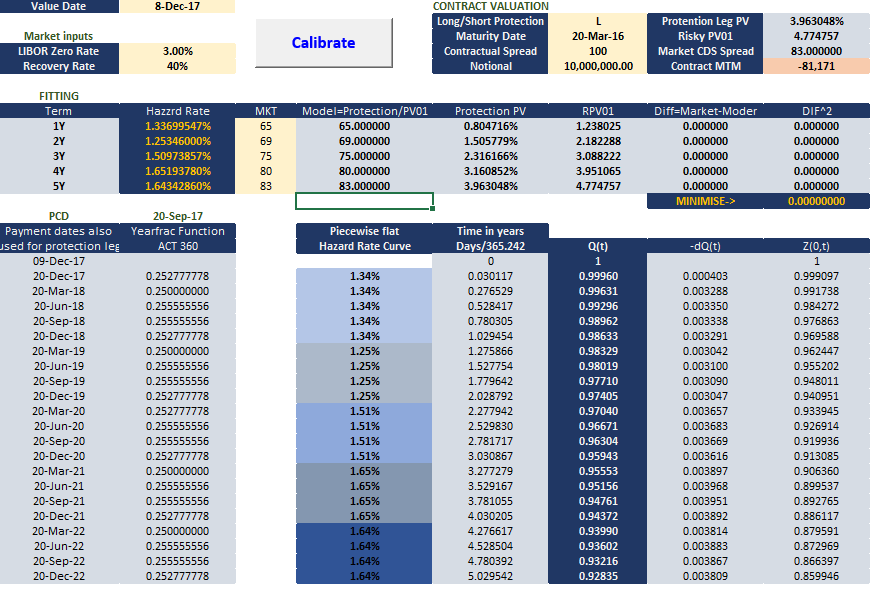

In [11]:
img_7b

### 7c. {-}

Now that we constructed the term strucutre of hazard rates and survival probabilities we can find the market spread at any given point in time. We will get the 3.5 years CDS market spread. To do this we need to use the following formula:

$$C=\frac{PV of Protection Leg}{RPV01}$$

As we previously stated, to get these values we need to use the following:

$$RPV01=\sum_{n=1}^{N}\Delta_{n}Q(t_{n})Z(t_{n})$$

On the excel sheet, this is done by applying a sumproduct function to the columns Yearfrac Function, Q(t) and Z(0,t). Yearfrac is the fraction of a year that represents each coupon payment. Q(t) is found by using the fact that $Q(0,T)=exp^{-\int_{0}^{T}h(s)ds}$ and that h(s) is piecewise flat. Finally, Z(0,t) are simply the discount factors.

$$Protection Leg PV = (1-R)\int_{0}^{T}Z(t)(-dQ(t))$$

On the excel sheet, this is done by multiplying (1-Recovery rate) times the sumproduct of the columns Z(0,t) and -dQ(t). Where -dQ(t) is simply the difference between Q(t) at any given point and the precedent Q(t-1). The obtained the 3.5 years CDS market spread is 77.828 basis points.

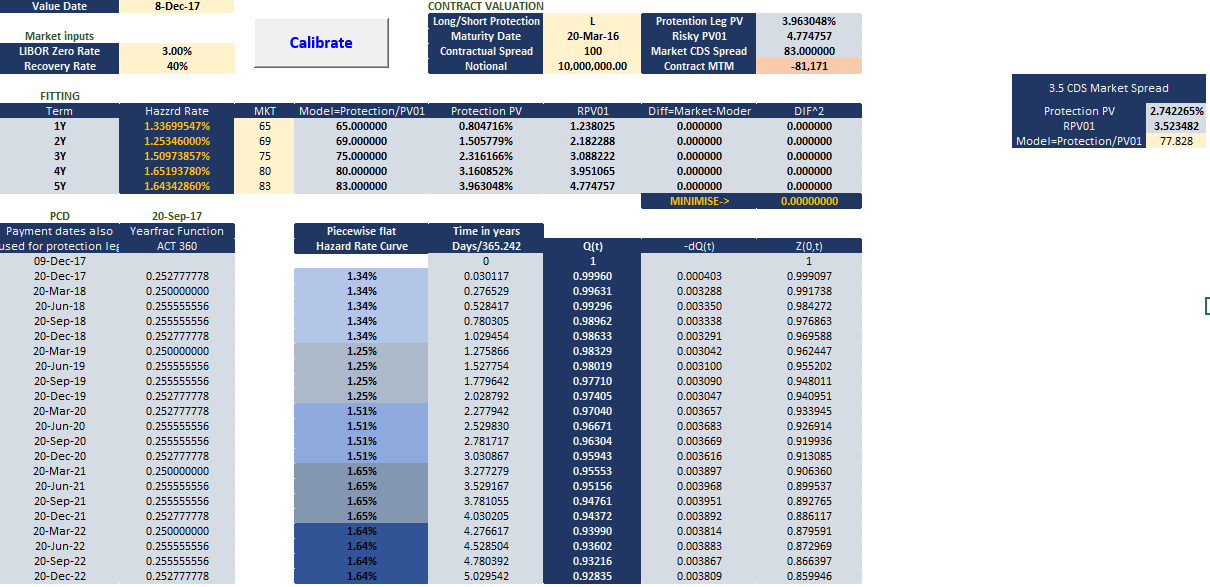

In [12]:
img_7c

### 7d. {-}

Next, we will use the above excercie to value a long protection CDS contract traded with a contractual spread of 115bps maturing the 20th June 2021 with a notional of $\$10$ millions. To do this we need to define the value of the protection leg as:

$$V(t) = (S(t,T)-C)\cdot RPV01(T,t)$$

This can be understood as the difference the protection buyer should pay to buy at the market quoted CDS spread at somewhat equal protection to the one he initially bought. The value we obtained was $\$130,974$.

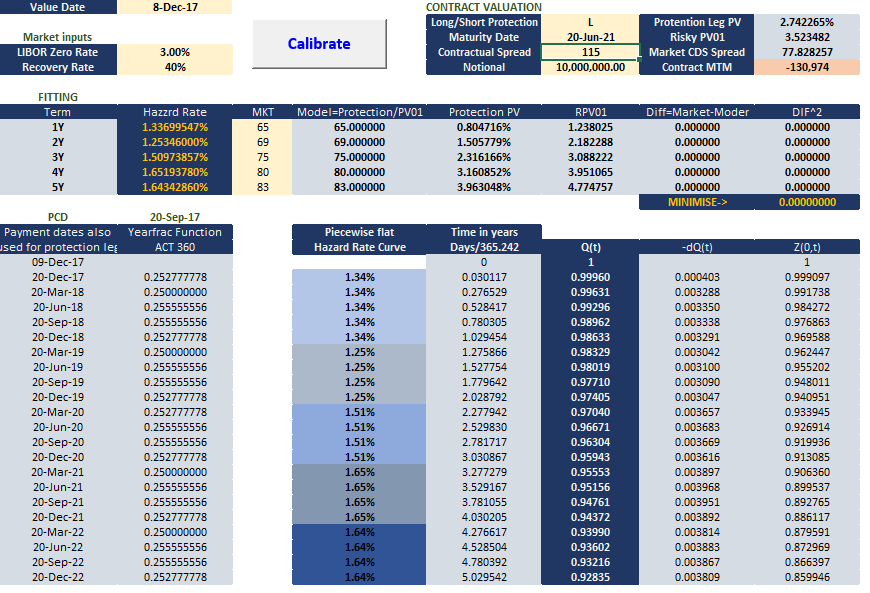

In [13]:
img_7d

### 7e. {-}

Now, we will look at how the computed value varies as we change the recovery rate.

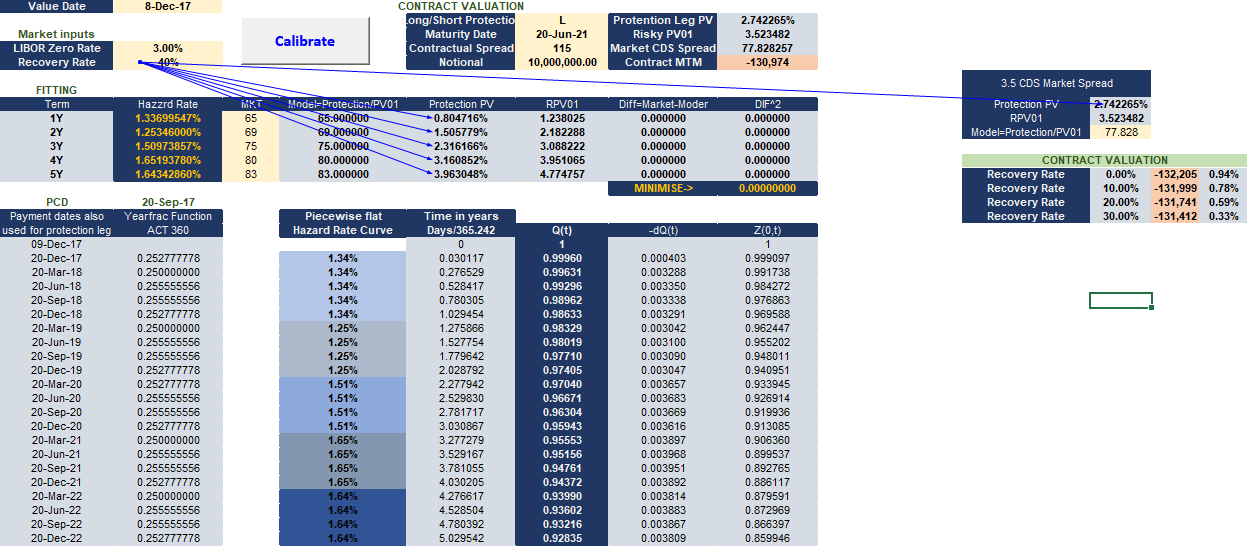

In [14]:
img_7e

As we can see from the image above, even when we change the recovery rate by a lot, the value of the CDS does not change by a lot. This makes sense as, at every change of R, the hazard rates are recomputed so that the probabilities of survival balance themselves to fit the market spreads. In practice, all the changes are almost exactly offset. This give us a hint that the most sensible part of the model is not the recovery rate but the market spreads.

### 7f. {-}

Finally, as we suggested above, we will see how the value of the CDS changes as each of the market spreads move by 1bps. The results are shown in the table below.

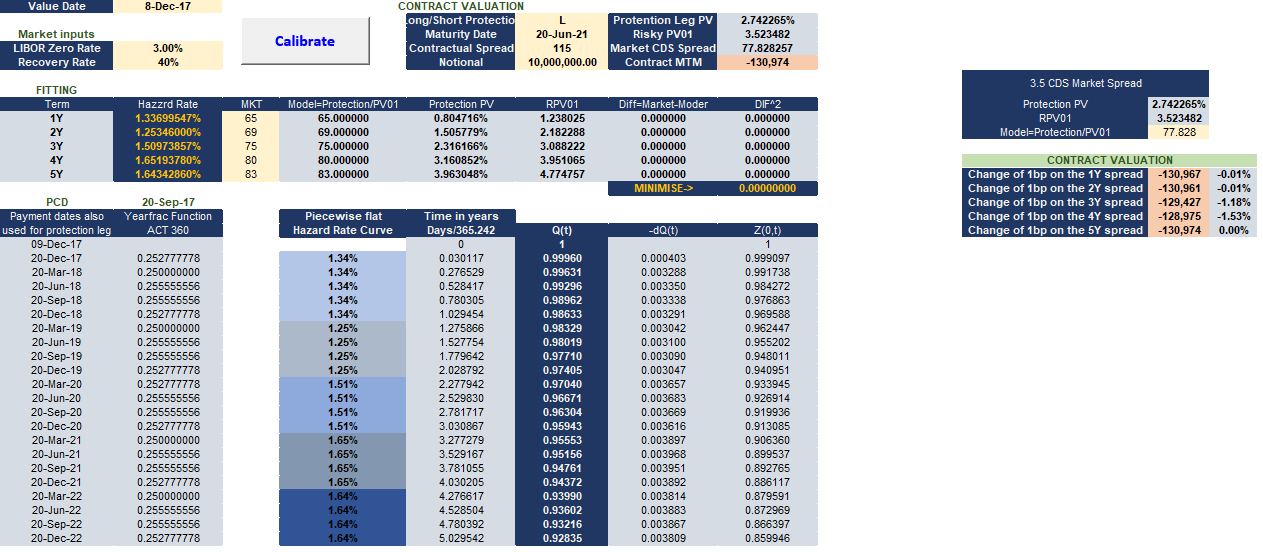

In [15]:
img_7f

As we can see from the image above, the main change comes from the changes in the 3 and 4 years market spreads. This makes sense as they are the nearest points of our 3.5 years CDS contract. Therefore to hedge the position, one could use two CDS maturing exactly in 3 and 4 years. The amount to have in each node will be a ratio of the changes in both the original contract and the hedging contrat given the change of the heding contract spread. This ratio will denote the sensitivity of our CDS to that specific spread.

# Question 8 - Bloomberg Pricing - One Touch Option {-}

For this question, we are going to value a One Touch option on the VIXY ETF that replicates the CBOE Volatility Index on the S&P500. The option we price was valued at December 1st 2021 when the spot price on the VIXY was $\$19.15$. The parameters we took for our option are the following:

1. It is an Up and In, Pay on Hit option (which mean that if the VIXY price goes above the stablished barrier, it will pay a prestlabished payoff)
2. The direction of the option is receiver
3. The barrier value was set to $\$22.00$
4. The maturity of the option is 2 years
5. The prestablished payoff is $\$1.00$ per option
6. We based the pricing on the Black & Scholes model, using the implied volatility provided by Bloomberg
7. The discount curve is based on the 3 month Libor curve
8. There is an all in Dividend Yield & Management fee rate of 0.850%

Except from the barrier level and the maturity of the option we used the inputs suggested by Bloomberg. To explain the motivation behind the barrier level, you can see below a graph of the historical price on the VIXY. As we can see, our proposed option would have resulted in a positive net payoff as the price went above the barrier in the following days. This type of option has the potential to partially hedge the downside risk on the market exposure as normally the VIX level goes up whenever there is a sharp fall in the S&P 500. 

In [48]:
# Here we upload the documents we will use

img_sel_curve = Image.open('One_Touch/Curve_Selection.png')
img_curve = Image.open('One_Touch/Curve.png')
img_Pricing = Image.open('One_Touch/Pricing.png')
img_vol_g = Image.open('One_Touch/Volatility_Grid.png')
img_price = Image.open('One_Touch/VIXY_price.jpeg')

curve = pd.read_excel('IRS Zero_Discount_Curve One Touch.xlsx', index_col=0, header=0, na_filter=True)
zeros = curve['Zero Rate']
discount = curve['Discount']
market_r = curve['Market Rate']

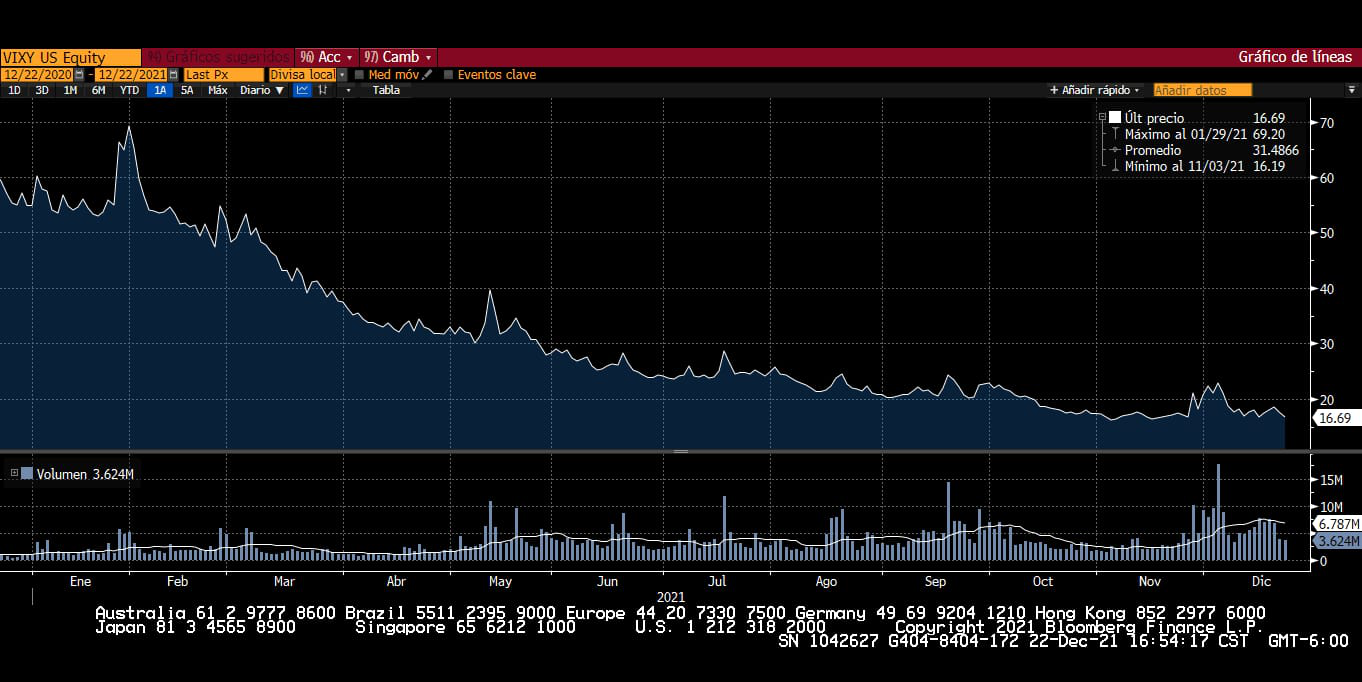

In [49]:
img_price

Below, you can see the Bloomber pricing Dashboard using the OVME option for equity securities. We specified the type of option to be a One Touch option with the parameters described above.

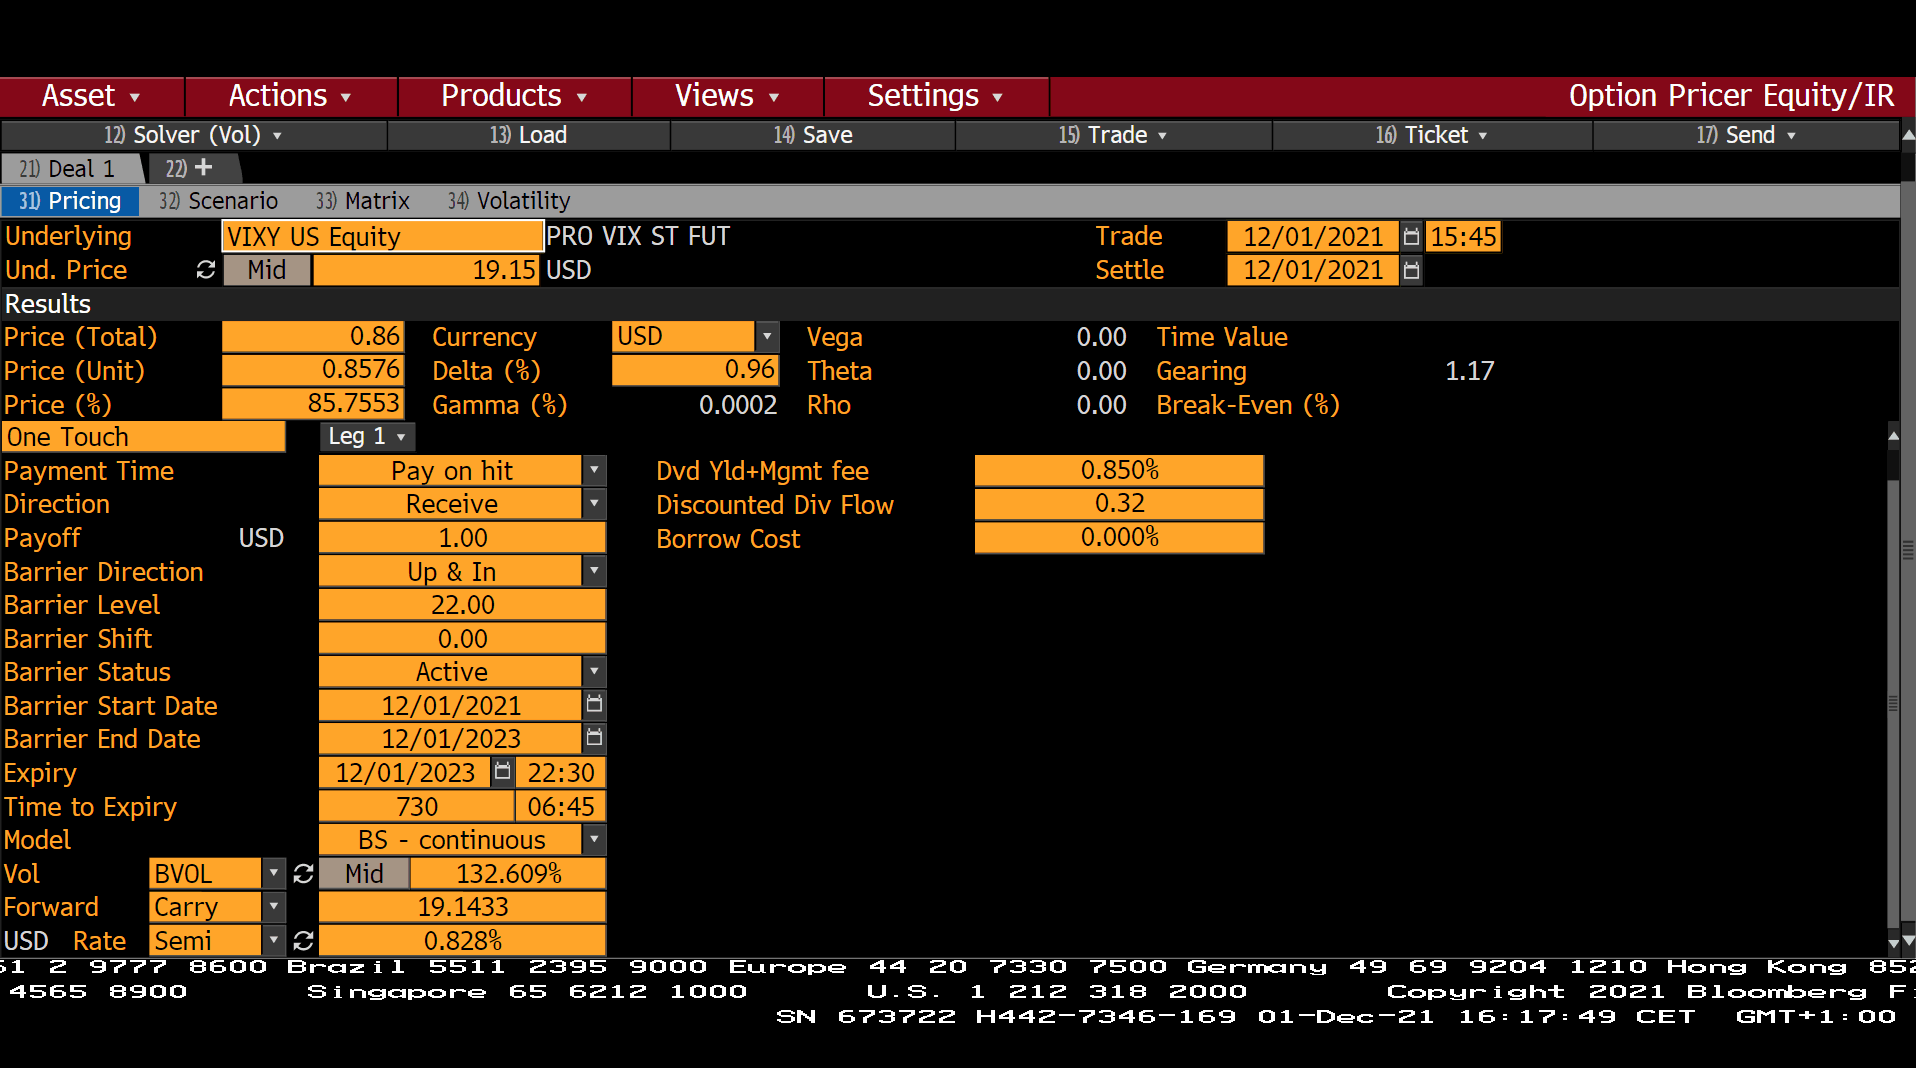

In [20]:
img_Pricing

Once on the dashboard it is possible to get information regarding the discount curve used to price the option and the implied volatility grid used to do so. Below, you can see both screenshots.

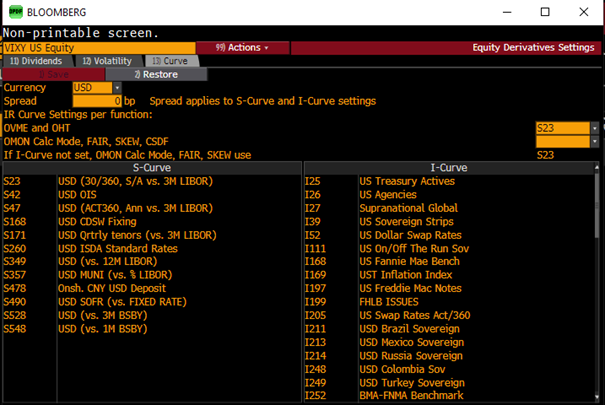

In [21]:
img_sel_curve

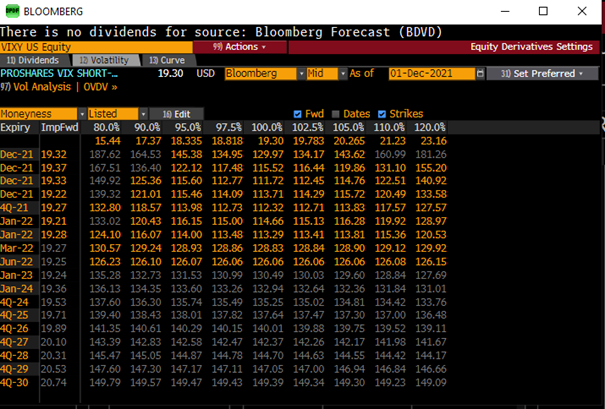

In [22]:
img_vol_g

Finally, we look for a more complete information about the discount curve that we identified that was used to price the option. Below, you can see both the Bloomberg Curve dashboard and a table with the corresponding values.

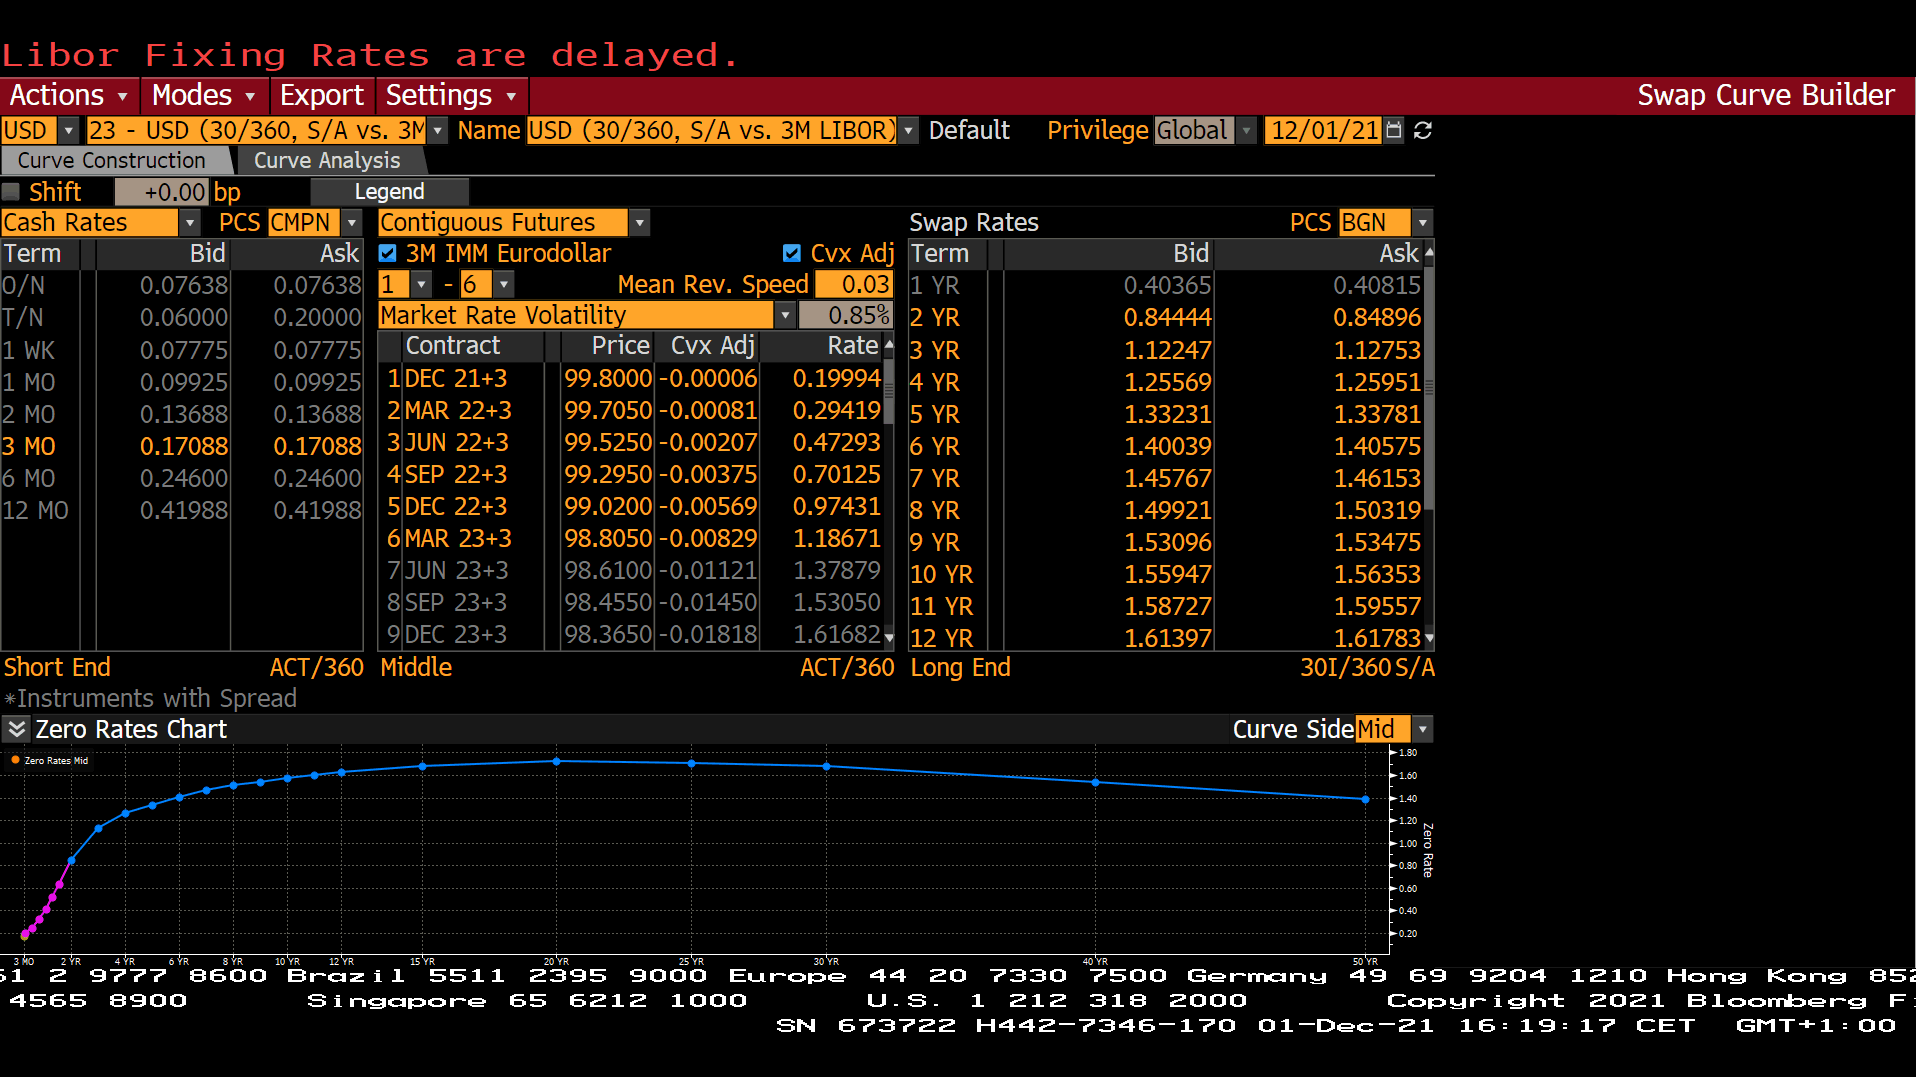

In [23]:
img_curve

In [24]:
curve

Market Rate  Shift (bp)  Shifted Rate  Zero Rate  Discount  \
Maturity Date                                                               
03/03/2022        0.170880           0      0.170880   0.173216  0.999573   
03/16/2022        0.199938           0      0.199938   0.199237  0.999438   
06/15/2022        0.294224           0      0.294224   0.245657  0.998695   
09/21/2022        0.478013           0      0.478013   0.325762  0.997397   
12/21/2022        0.701390           0      0.701390   0.417175  0.995632   
03/15/2023        0.979530           0      0.979530   0.520570  0.993362   
06/21/2023        1.187029           0      1.187029   0.638691  0.990162   
12/04/2023        0.847250           0      0.847250   0.847811  0.983164   
12/03/2024        1.125300           0      1.125300   1.126475  0.966741   
12/03/2025        1.257500           0      1.257500   1.259775  0.950825   
12/03/2026        1.335300           0      1.335300   1.338288  0.935241   
12/03/2027        1.404500           0      1.404500   1.408619  0.918920   
12/04/2028        1.460700           0      1.460700   1.465431  0.902397   
12/03/2029        1.502680           0      1.502680   1.508413  0.886250   
12/03/2030        1.535400           0      1.535400   1.541962  0.870349   
12/03/2031        1.564650           0      1.564650   1.572142  0.854447   
12/03/2032        1.593270           0      1.593270   1.601563  0.838363   
12/05/2033        1.618100           0      1.618100   1.627564  0.822398   
12/03/2036        1.669500           0      1.669500   1.681130  0.776970   
12/03/2041        1.712600           0      1.712600   1.725645  0.707962   
12/03/2046        1.702300           0      1.702300   1.709015  0.652115   
12/04/2051        1.679400           0      1.679400   1.677971  0.604255   
12/05/2061        1.574790           0      1.574790   1.542322  0.539326   
12/03/2071        1.452710           0      1.452710   1.385793  0.499898   

                      Source  
Maturity Date                 
03/03/2022              CASH  
03/16/2022            FUTURE  
06/15/2022            FUTURE  
09/21/2022            FUTURE  
12/21/2022            FUTURE  
03/15/2023            FUTURE  
06/21/2023            FUTURE  
12/04/2023     DETAILED_SWAP  
12/03/2024     DETAILED_SWAP  
12/03/2025     DETAILED_SWAP  
12/03/2026     DETAILED_SWAP  
12/03/2027     DETAILED_SWAP  
12/04/2028     DETAILED_SWAP  
12/03/2029     DETAILED_SWAP  
12/03/2030     DETAILED_SWAP  
12/03/2031     DETAILED_SWAP  
12/03/2032     DETAILED_SWAP  
12/05/2033     DETAILED_SWAP  
12/03/2036     DETAILED_SWAP  
12/03/2041     DETAILED_SWAP  
12/03/2046     DETAILED_SWAP  
12/04/2051     DETAILED_SWAP  
12/05/2061     DETAILED_SWAP  
12/03/2071     DETAILED_SWAP

From the table above, we can see that Bloomber already constructs a Zero coupon bond rate derived from the market rates. This is very useful when pricing cashflows in the future, as each cashflow has its corresponding discount rate. To price the chosen option in financpy, we will use both the zero discount curve and a flat curve to analyse the differences.

In [25]:
# We will import the missing classes from financepy to value an One Touch Option

from financepy.market.curves.discount_curve_flat import DiscountCurveFlat

In [27]:
# We define the parameters for the valuation

valuation_date = Date(1, 12, 2021)
expiry_date = Date(1, 12, 2023)
interest_rate = 0.00828
dividend_yield = 0.00850
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
volatility = 1.32609
barrier_level = 22.0
model = BlackScholes(volatility)
stock_price = 19.15
payment_size = 1.0

In [28]:
# Here, we create the option object and value the option assuming a flat discount curve

downTypes = [FinTouchOptionPayoffTypes.UP_AND_IN_CASH_AT_HIT]
print("%60s %12s %12s" % ("Option Type", "Analytical", "Monte Carlo"))
for downType in downTypes:
    option = EquityOneTouchOption(expiry_date,downType,barrier_level,payment_size)
    v = option.value(valuation_date,stock_price,discount_curve,dividend_curve,model)
    v_mc = option.value_mc(valuation_date,stock_price,discount_curve,dividend_curve,model)
    print("%60s %12.5f %12.5f" % (downType, v, v_mc))

                                                 Option Type   Analytical  Monte Carlo
             FinTouchOptionPayoffTypes.UP_AND_IN_CASH_AT_HIT      0.85681      0.81258


Now, we will repeat the valuation but using the actual discount curve. To do so, we will construct the discount curve starting from the observed market deposit and swap rates.

In [29]:
from financepy.products.rates import *

In [30]:
# We use market convention T+2 for settlement dates
spot_days = 2
settlement_date = valuation_date.add_days(spot_days)

## Ibor Deposits {-}

In [31]:
# We input the deposit rates we obtained from Bloomberg

dcType = DayCountTypes.ACT_360
depo1 = IborDeposit(settlement_date, '3M', market_r[1]/100, dcType)
depo2 = IborDeposit(settlement_date, '6M', market_r[2]/100, dcType)
depo3 = IborDeposit(settlement_date, '9M', market_r[3]/100, dcType)
depo4 = IborDeposit(settlement_date, '12M', market_r[4]/100, dcType)
depo5 = IborDeposit(settlement_date, '15M', market_r[5]/100, dcType)
depo6 = IborDeposit(settlement_date, '18M', market_r[6]/100, dcType)
depos = [depo1,depo2,depo3,depo4,depo5,depo6]
dcType = DayCountTypes.THIRTY_E_360_ISDA
fixedFreq = FrequencyTypes.SEMI_ANNUAL

## Interest Rate Swaps {-}

In [32]:
swapType = SwapTypes.PAY
swap1 = IborSwap(settlement_date,"2Y",swapType,market_r[7]/100,fixedFreq,dcType)
swap2 = IborSwap(settlement_date,"3Y",swapType,market_r[8]/100,fixedFreq,dcType)
swap3 = IborSwap(settlement_date,"4Y",swapType,market_r[9]/100,fixedFreq,dcType)
swap4 = IborSwap(settlement_date,"5Y",swapType,market_r[10]/100,fixedFreq,dcType)
swap5 = IborSwap(settlement_date,"6Y",swapType,market_r[11]/100,fixedFreq,dcType)
swap6 = IborSwap(settlement_date,"7Y",swapType,market_r[12]/100,fixedFreq,dcType)
swap7 = IborSwap(settlement_date,"8Y",swapType,market_r[13]/100,fixedFreq,dcType)
swap8 = IborSwap(settlement_date,"9Y",swapType,market_r[14]/100,fixedFreq,dcType)
swap9 = IborSwap(settlement_date,"10Y",swapType,market_r[15]/100,fixedFreq,dcType)
swap10 = IborSwap(settlement_date,"11Y",swapType,market_r[16]/100,fixedFreq,dcType)
swap11 = IborSwap(settlement_date,"12Y",swapType,market_r[17]/100,fixedFreq,dcType)
swap12 = IborSwap(settlement_date,"15Y",swapType,market_r[18]/100,fixedFreq,dcType)
swap13 = IborSwap(settlement_date,"20Y",swapType,market_r[19]/100,fixedFreq,dcType)
swap14 = IborSwap(settlement_date,"25Y",swapType,market_r[20]/100,fixedFreq,dcType)
swap15 = IborSwap(settlement_date,"30Y",swapType,market_r[21]/100,fixedFreq,dcType)
swap16 = IborSwap(settlement_date,"40Y",swapType,market_r[22]/100,fixedFreq,dcType)
swap17 = IborSwap(settlement_date,"50Y",swapType,market_r[23]/100,fixedFreq,dcType)

In [33]:
swaps = [swap1,swap2,swap3,swap4,swap5,swap6,swap7,
         swap8,swap9,swap10,swap11,swap12,swap13,swap14,swap15,swap16,swap17]

In [34]:
# From the rates specified above, we derive the implict FRAs
# We prepare the list to store the values

fras = []

# Bootstrapping The Curve {-}

In [35]:
libor_curve = IborSingleCurve(valuation_date, depos, fras, swaps)

## Extracting the Zero Rate Curves {-}

We choose a range of zero rate frequencies.

In [36]:
years = np.linspace(1/365,50,100)
dates = settlement_date.add_years(years)
zerosC = libor_curve.zero_rate(dates, FrequencyTypes.CONTINUOUS)

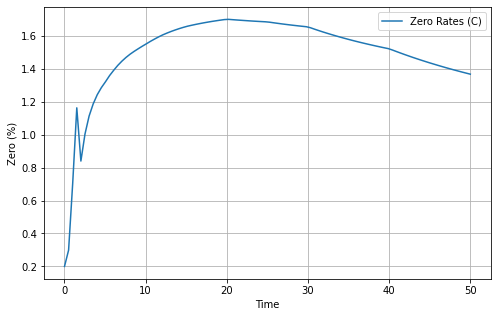

In [37]:
plt.figure(figsize=(8,5))
plt.plot(years,zerosC*100, label="Zero Rates (C)")
plt.xlabel("Time")
plt.ylabel("Zero (%)")
plt.legend()
plt.grid()

In [38]:
zeros_D_F = libor_curve.df(dates,dcType)
discount_curve_2 = DiscountCurve(valuation_date, dates, zeros_D_F)

In [39]:
downTypes = [FinTouchOptionPayoffTypes.UP_AND_IN_CASH_AT_HIT]
print("%60s %12s %12s" % ("Option Type", "Analytical", "Monte Carlo"))
for downType in downTypes:
    option2 = EquityOneTouchOption(expiry_date,downType,barrier_level,payment_size)
    v2 = option2.value(valuation_date,stock_price,discount_curve_2,dividend_curve,model)
    v2_mc = option2.value_mc(valuation_date,stock_price,discount_curve_2,dividend_curve,model)
    print("%60s %12.5f %12.5f" % (downType, v2, v2_mc))

                                                 Option Type   Analytical  Monte Carlo
             FinTouchOptionPayoffTypes.UP_AND_IN_CASH_AT_HIT      0.85682      0.81259


The analytical model produced the following sensitivities

In [40]:
option2.delta(valuation_date, stock_price, discount_curve_2, dividend_curve, model)

0.05018453356098185

In [41]:
option2.gamma(valuation_date, stock_price, discount_curve, dividend_curve, model)

4.9671378121729504e-05

In [42]:
option2.theta(valuation_date, stock_price, discount_curve, dividend_curve, model)

-0.008710353621571021

In [43]:
option2.vega(valuation_date, stock_price, discount_curve, dividend_curve, model)

0.027342039207178814

In [44]:
option2.rho(valuation_date, stock_price, discount_curve, dividend_curve, model)

0.024778375415923648

In [45]:
Results = pd.DataFrame(index=[valuation_date],columns=["Bloomberg Price", "Flat Curve Price", "Fitted Curve Price"])
Results.iloc[0,0]= 0.85760
Results.iloc[0,1]= np.round(v,5)
Results.iloc[0,2]=np.round(v2,5)
Results

Bloomberg Price Flat Curve Price Fitted Curve Price
01-DEC-2021          0.8576          0.85681            0.85682

As we can see, the prices of both the flat curve and the fitted curve are pretty close to that obtained from Bloomberg. This makes sense as we took the sames inputs. Nonetheless, there might be some structural differences, specially in the way that dividends are being discounted. We use a flat curve to discount the dividends assuming that the dividend rate provided in the bloomberg pricing page was the continous dividend rate. Both assumptions might be having an impact regarding our pricing using the financepy in-built functions. 